# Итоговое задание юнита 6
# Выбираем авто выгодно.

# Часть 2: Анализ данных и подготовка модели для соревнования на Kaggle.

Проект посвящён вопросам качественной оценки стоимости предлагаемых автомобилей. Необходимо создать модель на основе продвинутых методов машинного обучения, не применяя технику нейронных сетей.

Отличительная черта данного проекта состоит в том, что он не содержит тренировчного набора, поэтому в процессе работы следует:
* провести анализ тестовых данных;
* самостоятельно провести сбор данных для обучения;
* провести детальный анализ и модификацию собранной информации;
* выбрать наиболее удачную модель на основе анализа данных;
* обучить модель для задачи оценки стоимости автомобиля;
* провести моделирование на основе тестовых данных;
* принять участие в соревновании на Kaggle.


Данный ноутбук предназначен для анализа данных после выполнения ноутбука №1 и дальнейшего построения модели с созданием сабмита для соревнования на Kaggle. 

## Импорт библиотек.

In [1]:
# Загружаем необходимые библиотеки.

# Импорт необходимых библитек.
import pandas as pd
import numpy as np

# Импорт библиотек для работы с json.
import json

# Импорт библиотек для запросов.
import requests

# Импотр библиотек для работы с файловой системой.
import os
from csv import DictWriter
from pathlib import Path

# Графика.
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.base import clone
import xgboost as xgb

# Вспомогательные библиотеки.
import time
import argparse
from collections import namedtuple, defaultdict
import warnings
import re
from functools import partial

## Предварительные настройки

In [2]:
# Отключаем все возможные предупреждения.
warnings.filterwarnings("ignore")

# Сброс ограничений на число столбцов.
pd.set_option('display.max_columns', None)

# Идентификатор каталога исходных данных
INPUT_PATH = './kaggle/input/sf-dst-car-price-prediction/'

# Для ML.
RANDOM_STATE = 43

In [3]:
# Проводим анализ: какие файлы присутствуют в рабочем каталоге.
for dirname, _, filenames in os.walk(INPUT_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./kaggle/input/sf-dst-car-price-prediction/cut_train.csv
./kaggle/input/sf-dst-car-price-prediction/data_2021_09_27.csv
./kaggle/input/sf-dst-car-price-prediction/sample_submission.csv
./kaggle/input/sf-dst-car-price-prediction/test.csv
./kaggle/input/sf-dst-car-price-prediction/train.csv


# Этот блок надо удалить

In [4]:
#train = []
#for file_name in os.listdir(INPUT_PATH):
#    train.append(pd.read_csv(os.path.join(INPUT_PATH,file_name)))
#train = pd.concat(train)

In [5]:
#train.shape

In [6]:
#train.to_csv(INPUT_PATH+'train.csv')

## Блок функций.

In [7]:
#+++++++++++++++++++++++++++

def data_type(row):
    '''
    Определяет тип данных.
    На входе: - запись из базы данных.
    На выходе: - запись с типом данных.
    '''
    
    row = row.apply(lambda x: type(x))
    return row

#+++++++++++++++++++++++++++

def fill_na(df):
    '''
    метод заполнения столбцов с пропусками
    '''
    
    df.loc[df.engineDisplacement == ' LTR', 'engineDisplacement'] = None
    df.loc[df.ПТС.isna(),'ПТС'] = 'Оригинал'
    df.loc[df.Владельцы.isna(),'Владельцы'] = 'Неизвестно'
    
#+++++++++++++++++++++++++++
    
def change_engine_type(df):
    '''
    Метод изменения формата данных в признаках о двигателях.
    '''
    
    df.engineDisplacement = df.engineDisplacement.str.replace('LTR','').astype(float)
    df.enginePower = df.enginePower.str.replace('N12','').astype(float)
    
#+++++++++++++++++++++++++++

def get_months(months):
    '''
    Метод формирования строки для месяца.
    '''    
    
    if months == 1:
        return f'{months} месяц'
    elif 2 <= months <= 4:
        return f'{months} месяца'
    return f'{months} месяцев'

#+++++++++++++++++++++++++++

def gеt_years(years):
    '''
    Метод формирования строки для года.
    ''' 
    
    if 11 <= years <= 14 or 5 <= years%10 <= 9 or years%10 == 0:
        return f'{years} лет'
    elif years%10 == 1:
        return f'{years} год'
    elif 2 <= years%10 <= 4:
        return f'{years} годa'

#+++++++++++++++++++++++++++    
    
def vl_parsing(row):
    '''
    Метод разбора строки Владение.
    '''
    if row is np.nan: return
    row = re.findall('\d+',row)
    if row != []:
        years = 2020 - (int(row[0])+1)
        months = 2 +(12 - int(row[1]))
        if years < 0:
            return get_months(int(row[1]))
        elif years == 0 and months < 12:
            return get_months(months)
        elif years >= 0 and months == 12:
            return gеt_years(years + 1)
        elif years >= 0 and months > 12:
            return gеt_years(years + 1)+' и '+get_months(months - 12)
        elif years > 0 and months < 12:
            return gеt_years(years)+' и '+get_months(months)
        return 'nodata'

#+++++++++++++++++++++++++++

def get_months_count(row):
    '''
    Метод расчёта количества месяцев владения.
    '''
    
    if pd.notnull(row) and row!='nodata':
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])
    
#+++++++++++++++++++++++++++    

def ed_volume(row):
    '''
    Метод преобразования типа.
    '''
    
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return 0.0
    return int(float(volume[0])*1000)

#+++++++++++++++++++++++++++    

def mape_calc(y_true, y_pred):
    '''
    Метод расчёта средней ошибки.
    '''
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#+++++++++++++++++++++++++++    
    
def model_fit(model, X, y):
    '''
    Метод выполнения перекрёстной проверки.
    '''
    
    # Перекрёстная проверка.
    kfold = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    cv_results = cross_val_score(model, X, y, cv=kfold, n_jobs=-1, scoring=make_scorer(mape_calc))
    
    # Обучение на наборе.
    model.fit(X_train,y)
    y_pred = model.predict(X_train)
    train_score = mape_calc(y, y_pred)

    # Выводим результаты.
    print(f'MAPE на тренировочном наборе: {train_score}')
    print(f'MAPE на перекрёстной проврке: {np.mean(cv_results)} ({cv_results})')
    
#+++++++++++++++++++++++++++       

def write_submition(df, my_model, X_test, file):
    '''
    Метод оценивания тестовых данных и записи submit.
    '''    
 
    y_submit = np.round(my_model.predict(X_test))
    submit = pd.Series(y_submit, index=df[df.Train==0].sell_id, name='price')
    submit.to_csv(file)
    
#+++++++++++++++++++++++++++       


def splitter(df, cat_columns, num_columns):
    '''
    Метод подготовки и разделения данных на тестовую и тренировочную для ML.
    '''   
    
    # Выбрали все интересующие столбцы.
    X = df.loc[:, cat_columns+num_columns+['Train']]

    # Создаём дамми переменые.
    X = pd.get_dummies(X, columns=cat_columns)
    X[num_columns] = StandardScaler().fit_transform(X[num_columns])
    
    # По трейну выделяем тренировочные данные.
    X_train =  X[X.Train == 1]
    X_train.drop('Train', axis=1)
    
    # И тестовые данные.
    X_test = X[X.Train == 0]
    X_test.drop('Train', axis=1)

    # Выделяяем вектор ответа.
    y = df[df.Train == 1].price

    return X_train, X_test, y

#+++++++++++++++++++++++++++


def json_parse(row, column):
    '''
    Функция предназначена для парсинга признаков super_gen,...
    '''
    
    if row[column] is np.nan:
        value = None
    elif row.Train==1:
        value = eval(row[column])
    else:
        value = json.loads(row[column])
    
    return value if value else None

#+++++++++++++++++++++++++++

def create_df(df, column):
    '''
    Функция предназначена для создания датасета распарсенных столбца признаков super_gen,...
    
    '''"
    
    json_series = df.apply(partial(json_parse, column=column), axis=1)
    json_df = json_series.apply(pd.Series)
    return json_df

#+++++++++++++++++++++++++++

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    '''
    Функция реализующая технологию стекинга.
    '''    
    
    X_meta_train = np.zeros((len(y_train)), dtype=np.float32)

    splits = cv.split(X_train)
    
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict(X_test)
    
    return X_meta_train, X_meta_test

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    '''
    Функция подготовки первоначальных данных для технологии стекинга.
    '''
    
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ]).reshape(-1,len(features), order='F')

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ]).reshape(-1,len(features), order='F')
    
    return stacked_features_train, stacked_features_test

#+++++++++++++++++++++++++++

## 2.1. Анализ данных тренировочного набора.

Загружаем тренировчный набор.

In [8]:
train = pd.read_csv(INPUT_PATH+'train.csv');

Проведём беглый обзор данных.

In [9]:
train.sample(20) # Тренировочный набор.

,Unnamed: 0,Unnamed: 0.1,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,location,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
273725,273725,518,Лифтбек,Skoda,https://auto.ru/cars/used/sale/skoda/octavia/1...,FAFBFB,"{'id': '10375166', 'name': 'Active', 'availabl...","Машина в отличном состоянии, делать ничего не ...",1.6 LTR,90 N12,Москва,"{'steel-wheels': True, 'airbag-driver': True, ...",DIESEL,//avatars.mds.yandex.net/get-autoru-vos/167674...,118000,2013,"{'code': 'OCTAVIA', 'name': 'Octavia', 'ru_nam...",Octavia,1.6d MT (90 л.с.),5,1633208307407,RUR,2015,1105234993-98745048,"{'id': '9338208', 'name': 'III (A7)', 'ru_name...",LIFTBACK MECHANICAL 1.6,MECHANICAL,EUROPEAN,2.0,NaN,ORIGINAL,FORWARD_CONTROL,LEFT,True,True,840000
706794,706794,978,Внедорожник 5 дв.,Audi,https://auto.ru/cars/used/sale/audi/q3/1105484...,22A0F8,"{'id': '0', 'name': ''}",Автомобиль в хорошем техническом состоянии. По...,2.0 LTR,220 N12,Москва,"{'cruise-control': True, 'asr': True, 'esp': T...",GASOLINE,//avatars.mds.yandex.net/get-autoru-vos/523344...,95000,2014,"{'code': 'Q3', 'name': 'Q3', 'ru_name': 'Ку3'}",Q3,2.0 AMT (220 л.с.) 4WD,5,1633182637000,RUR,2016,1105484509-bf75335f,"{'id': '20293979', 'name': 'I (8U) Рестайлинг'...",ALLROAD_5_DOORS ROBOT 2.0,ROBOT,EUROPEAN,2.0,NaN,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,True,True,2190000
602169,602169,1766,Седан,Volkswagen,https://auto.ru/cars/used/sale/volkswagen/polo...,CACECB,"{'id': '21380757', 'name': 'Comfortline', 'ava...",Один владелец!!!\nАвтоцентр Атлант-М Бажова - ...,1.6 LTR,85 N12,Москва,"{'cruise-control': True, 'engine-proof': True,...",GASOLINE,//avatars.mds.yandex.net/get-autoru-vos/523227...,74000,2014,"{'code': 'POLO', 'name': 'Polo', 'ru_name': 'П...",Polo,1.6 MT (85 л.с.),4,1633179405000,RUR,2016,1105483825-8ec275f8,"{'id': '20113124', 'name': 'V Рестайлинг', 'ru...",SEDAN MECHANICAL 1.6,MECHANICAL,EUROPEAN,1.0,NaN,ORIGINAL,FORWARD_CONTROL,LEFT,True,True,810000
728139,728139,123,Внедорожник 5 дв.,Infiniti,https://auto.ru/cars/used/sale/infiniti/qx50/1...,040001,"{'id': '0', 'name': ''}","Автомобиль в отличном техническом состоянии, п...",2.0 LTR,272 N12,Москва,"{'cruise-control': True, 'asr': True, 'tinted-...",GASOLINE,//avatars.mds.yandex.net/get-autoru-vos/523244...,84000,2017,"{'code': 'QX50', 'name': 'QX50', 'ru_name': 'к...",QX50,2.0 CVT (272 л.с.),5,1633164884000,RUR,2018,1105023350-ae3afbfd,"{'id': '21172112', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS VARIATOR 2.0,VARIATOR,JAPANESE,1.0,NaN,ORIGINAL,FORWARD_CONTROL,LEFT,True,True,3200000
483834,483834,1276,Внедорожник 5 дв.,Audi,https://auto.ru/cars/used/sale/audi/q5/1105063...,200204,"{'id': '0', 'name': ''}","Пожалуйста, получите лучшее предложение у Ваше...",2.0 LTR,225 N12,Люберцы,"{'cruise-control': True, 'electro-window-back'...",GASOLINE,//avatars.mds.yandex.net/get-autoru-vos/523186...,71000,2012,"{'code': 'Q5', 'name': 'Q5', 'ru_name': 'Ку5'}",Q5,2.0 AT (225 л.с.) 4WD,5,1633180266302,RUR,2013,1105063232-17c61c77,"{'id': '8351293', 'name': 'I (8R) Рестайлинг',...",ALLROAD_5_DOORS AUTOMATIC 2.0,AUTOMATIC,EUROPEAN,1.0,NaN,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,True,True,2150000
972572,239006,535,Внедорожник 5 дв.,Mercedes-Benz,https://auto.ru/cars/used/sale/mercedes-benz/g...,040001,"{'id': '0', 'name': ''}","Состояние хорошее, нету нареканий, зимняя нова...",3.0 LTR,240 N12,Москва,{},DIESEL,//avatars.mds.yandex.net/get-autoru-vos/458061...,214000,2012,"{'code': 'GL_KLASSE', 'name': 'GL-Класс', 'ru_...",GL-Класс,350 CDI BlueTEC 3.0d AT (240 л.с.) 4WD,5,1632547459000,RUR,2013,1105394490-5b39c644,"{'id': '8225665', 'name': 'II (X166)', 'ru_nam...",ALLROAD_5_DOORS AUTOMATIC 3.0,AUTOMATIC,EUROPEAN,3.0,NaN,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,True,True,2900000
292662,292662,1066,Внедорожни

Напомним, что у нас за признаки.
* bodyType - вид транспортного средства (седан, джип, кабриолет,..);
* brand - марка автомобиля;
* car_url - скорее всего ссылка на объявление (попробовать проверить);
* color - цвет автомобиля;
* complectation_dict - некое описание комплектации;
* description - какая-то полезная информация по автомобилю;
* car - флаг наличия автомобиля;
* engineDisplacement - кубики двигателя;
* enginePower - количество лошадиных сил;
* fuelType - тип топлива;
* image - ссылка на фото (попробовать проверить);
* mileage - пробег;
* modelDate - год начала продаж (ну или когда презентовали эту модель);
* model_name - модель автомобиля;
* name - некая спецификация;
* numberOfDoors - количество дверей;
* parcing_unix_date - какая-то странная дата..;
* priceCurrency - валюта, в которой продаётся автомобиль;
* productionDate - год выпуска;
* sell_id - наверное идентификатор продавца;
* super_gen - вспомогательная информация;
* vehicleConfiguration - конфигурация автомобиля;
* vehicleTransmission - тип кпп;
* vendor - место производства;
* Владельцы - количество владельцев;
* Владение - срок нахождения у владельца;
* ПТС - полагаю, либо оригинал, либо дубликат;
* Привод - передний, задний;
* Руль - расоложение руля;
* Состояние - не бита, не крашена, ездила девушка;
* Таможня - даёт добро.

In [10]:
train.info() # Тренировочный набор.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021987 entries, 0 to 1021986
Data columns (total 36 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Unnamed: 0            1021987 non-null  int64  
 1   Unnamed: 0.1          1021987 non-null  int64  
 2   bodyType              1021987 non-null  object 
 3   brand                 1021987 non-null  object 
 4   car_url               1021987 non-null  object 
 5   color                 1021987 non-null  object 
 6   complectation_dict    1021987 non-null  object 
 7   description           991162 non-null   object 
 8   engineDisplacement    1021987 non-null  object 
 9   enginePower           1021987 non-null  object 
 10  location              1021987 non-null  object 
 11  equipment_dict        1021987 non-null  object 
 12  fuelType              1021987 non-null  object 
 13  image                 1021987 non-null  object 
 14  mileage               1021987 non-

Сделаем краткие выводы.
Итак, в тренировочном наборе:
* признак "bodyType" - тип кузова начинается с большой буквы - исправить;
* признак "brand" - марка автомобиля так же начинается с большой - исправить;
* признак "color" - задан в 16ричном формате - исправить;
* признак "fuelType" - на английском - исправить;
* признак "model_name" - с маленькой буквы - исправить;
* признак "priceCurrency" - странный RUR - оценить сколько типов в этом столбце;
* признак "vehicleTransmission" - на анлийском - исправить;
* признак "Владельцы" - привести в соответствие;
* признак "Владение" - привести в соответствие;
* Так же привести в соответствие признаки "ПТС", "Привод", "Руль", "Состояние", "Таможня".
* появились странные поля "index", "Unnamed: 0", "Unnamed: 0.1", "location" - где-то перестарался с парсингом и созданием объединённого файла. Удалю их потом.


Сделаем анализ пропусков по аналогии с тестовым набором.

	Пропуски тренеровочного набора


Unnamed: 0                   0
Unnamed: 0.1                 0
bodyType                     0
brand                        0
car_url                      0
color                        0
complectation_dict           0
description              30825
engineDisplacement           0
enginePower                  0
location                     0
equipment_dict               0
fuelType                     0
image                        0
mileage                      0
modelDate                    0
model_info                   0
model_name                   0
name                         0
numberOfDoors                0
parsing_unixtime             0
priceCurrency                0
productionDate               0
sell_id                      0
super_gen                    0
vehicleConfiguration         0
vehicleTransmission          0
vendor                       0
Владельцы               249781
Владение                945611
ПТС                      10708
Привод                       0
Руль    

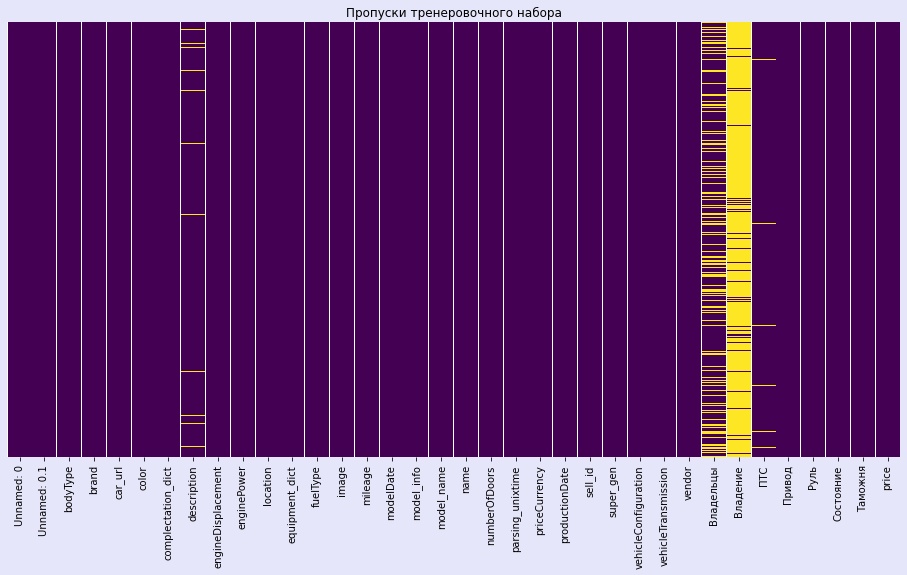

In [11]:
# Проверим и визуализируем пропуски тренировочного набора.
print('\tПропуски тренировочного набора')
display(train.isnull().sum())  # Тестовый набор.

# Визуализируем пропуски.
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax);

# Подписываем.
ax.set_title("Пропуски тренировочного набора");

Большие проблемы с признаком "Владение", подумать что делать со столь большим объёмом данных..
Признаки "Владельцы", "ПТС" думаю можно заполнить; что делать с признаком, соответствующим описанию, пока ещё не решил, что делать.

## Исправим несогласованности.

### Признак "bodyType".

In [12]:
# Делаем все символы нижним регистром.
train.bodyType = train.bodyType.str.lower();

# Посмотрим, что получилось.
print('Случайная выборка.')
train.bodyType.sample(10).values

Случайная выборка.


array(['внедорожник 5 дв.', 'внедорожник 5 дв.', 'купе', 'седан',
       'внедорожник 5 дв.', 'внедорожник 5 дв.', 'внедорожник 5 дв.',
       'седан', 'внедорожник 5 дв.', 'седан'], dtype=object)

In [13]:
# Посмотрим на уникальные значения.
print(f'Количество уникальных значений: {train.bodyType.nunique()}')
print('Уникальные значения.')
train.bodyType.unique()

Количество уникальных значений: 100
Уникальные значения.


array(['внедорожник 5 дв.', 'хэтчбек 3 дв.', 'универсал 5 дв.', 'седан',
       'хэтчбек 5 дв.', 'минивэн', 'седан long', 'купе-хардтоп', 'купе',
       'хэтчбек 5 дв. sportback', 'лифтбек gran turismo', 'фургон kasten',
       'лифтбек', 'пикап полуторная кабина', 'компактвэн', 'минивэн xl',
       'минивэн l', 'компактвэн gran tourer', 'минивэн long',
       'седан japan market', 'пикап двойная кабина arctic trucks',
       'пикап двойная кабина', 'лифтбек sportback', 'внедорожник 3 дв.',
       'внедорожник 5 дв. arctic trucks', 'минивэн l3',
       'лифтбек gran coupe', 'пикап двойная кабина double cab', 'фургон',
       'внедорожник 5 дв. l', 'хэтчбек 5 дв. phv', 'минивэн swb',
       'пикап одинарная кабина', 'минивэн lwb', 'минивэн spada',
       'седан type-s', 'купе asti', 'кабриолет', 'универсал 5 дв. scout',
       'микровэн', 'седан gran coupe', 'универсал 5 дв. shuttle',
       'седан 120', 'универсал 5 дв. plus', 'универсал 5 дв. xc',
       'компактвэн spike', 'седан us 

Столько мусора! Ничего себе как sample отработал..
Исправляем..

In [14]:
# Сначала с длинными названиями, потом с короткими, чтобы избежать всяких 'минивэн3'
train.bodyType = train.bodyType.str.replace(' arctic trucks','')
train.bodyType = train.bodyType.str.replace(' asian market','')
train.bodyType = train.bodyType.str.replace(' gran turismo','')
train.bodyType = train.bodyType.str.replace(' japan market','')
train.bodyType = train.bodyType.str.replace(' gran tourer','')
train.bodyType = train.bodyType.str.replace(' kasten maxi','')
train.bodyType = train.bodyType.str.replace(' all-terrain','')
train.bodyType = train.bodyType.str.replace(' marco polo','')
train.bodyType = train.bodyType.str.replace(' double cab','')
train.bodyType = train.bodyType.str.replace(' gran coupe','')
train.bodyType = train.bodyType.str.replace(' single cab','')
train.bodyType = train.bodyType.str.replace(' us market','')
train.bodyType = train.bodyType.str.replace(' march box','')
train.bodyType = train.bodyType.str.replace(' sportback','')
train.bodyType = train.bodyType.str.replace(' extralong','')
train.bodyType = train.bodyType.str.replace(' alltrack','')
train.bodyType = train.bodyType.str.replace(' allspace','')
train.bodyType = train.bodyType.str.replace(' king cab','')
train.bodyType = train.bodyType.str.replace(' long bed','')
train.bodyType = train.bodyType.str.replace(' liftback','')
train.bodyType = train.bodyType.str.replace(' pullman','')
train.bodyType = train.bodyType.str.replace(' del sol','')
train.bodyType = train.bodyType.str.replace(' fielder','')
train.bodyType = train.bodyType.str.replace(' xtracab','')
train.bodyType = train.bodyType.str.replace(' crewmax','')
train.bodyType = train.bodyType.str.replace(' compact','')
train.bodyType = train.bodyType.str.replace(' shuttle','')
train.bodyType = train.bodyType.str.replace(' gracia','')
train.bodyType = train.bodyType.str.replace(' type-s','')
train.bodyType = train.bodyType.str.replace(' kasten','')
train.bodyType = train.bodyType.str.replace(' lucida','')
train.bodyType = train.bodyType.str.replace(' premio','')
train.bodyType = train.bodyType.str.replace(' qualis','')
train.bodyType = train.bodyType.str.replace(' latio','')
train.bodyType = train.bodyType.str.replace(' extra','')
train.bodyType = train.bodyType.str.replace(' cross','')
train.bodyType = train.bodyType.str.replace(' scout','')
train.bodyType = train.bodyType.str.replace(' scout','')
train.bodyType = train.bodyType.str.replace(' ceres','')
train.bodyType = train.bodyType.str.replace(' spada','')
train.bodyType = train.bodyType.str.replace(' spike','')
train.bodyType = train.bodyType.str.replace(' emina','')
train.bodyType = train.bodyType.str.replace(' ardeo','')
train.bodyType = train.bodyType.str.replace(' cross','')
train.bodyType = train.bodyType.str.replace(' hobio','')
train.bodyType = train.bodyType.str.replace(' blit','')
train.bodyType = train.bodyType.str.replace(' asti','')
train.bodyType = train.bodyType.str.replace(' plus','')
train.bodyType = train.bodyType.str.replace(' life','')
train.bodyType = train.bodyType.str.replace(' t140','')
train.bodyType = train.bodyType.str.replace(' maxi','')
train.bodyType = train.bodyType.str.replace(' noah','')
train.bodyType = train.bodyType.str.replace(' long','')
train.bodyType = train.bodyType.str.replace(' gita','')
train.bodyType = train.bodyType.str.replace(' 4x4','')
train.bodyType = train.bodyType.str.replace(' joy','')
train.bodyType = train.bodyType.str.replace(' 120','')
train.bodyType = train.bodyType.str.replace(' swb','')
train.bodyType = train.bodyType.str.replace(' phv','')
train.bodyType = train.bodyType.str.replace(' lwb','')
train.bodyType = train.bodyType.str.replace(' 76','')
train.bodyType = train.bodyType.str.replace(' 79','')
train.bodyType = train.bodyType.str.replace(' gr','')
train.bodyType = train.bodyType.str.replace(' 78','')
train.bodyType = train.bodyType.str.replace(' l2','')
train.bodyType = train.bodyType.str.replace(' l1','')
train.bodyType = train.bodyType.str.replace(' l3','')
train.bodyType = train.bodyType.str.replace(' xl','')
train.bodyType = train.bodyType.str.replace(' xc','')
train.bodyType = train.bodyType.str.replace(' xl','')
train.bodyType = train.bodyType.str.replace(' xc','')
train.bodyType = train.bodyType.str.replace(' l','')

In [15]:
# Посмотрим ещё раз.
print(f'Количество уникальных значений: {train.bodyType.nunique()}')
print('Уникальные значения.')
train.bodyType.unique()

Количество уникальных значений: 22
Уникальные значения.


array(['внедорожник 5 дв.', 'хэтчбек 3 дв.', 'универсал 5 дв.', 'седан',
       'хэтчбек 5 дв.', 'минивэн', 'купе-хардтоп', 'купе', 'лифтбек',
       'фургон', 'пикап полуторная кабина', 'компактвэн',
       'пикап двойная кабина', 'внедорожник 3 дв.',
       'пикап одинарная кабина', 'кабриолет', 'микровэн', 'родстер',
       'седан-хардтоп', 'седан 2 дв.', 'лимузин', 'внедорожник открытый'],
      dtype=object)

Собственно, есть небольшая проблема. В тестовом образце 24 уникальных кузова. Чуть позже надо будет вернуться к этому вопросу.

### Признак "color".

Признак "color" спарсился как 16ричное число. Преобразовуем их.

In [16]:
# Создаём словарь.
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}

# Делаем замену.
train.color = train.color.map(dict_color)

# Проверим, что получилось.
train.color.value_counts()

чёрный         317205
белый          231013
серый          135313
синий           89543
серебристый     82239
коричневый      53650
красный         35717
бежевый         27597
голубой         21192
зелёный         13252
фиолетовый       6998
пурпурный        3042
жёлтый           2581
оранжевый        1423
золотистый       1209
розовый            13
Name: color, dtype: int64

### Признак "vehicleTransmission".

Переведём на русский как в тесте.

In [17]:
# Словарь.
fuel_dict = {
    'DIESEL':'дизель',
    'GASOLINE':'бензин',
    'LPG':'газ',
    'HYBRID':'гибрид',
    'ELECTRO':'электро'}

# Делаем замену.
train.fuelType = train.fuelType.map(fuel_dict)

# Проверим, что получилось.
train.fuelType.value_counts()

бензин     611690
дизель     359611
гибрид      48897
газ           985
электро       804
Name: fuelType, dtype: int64

### Признак "Руль".

Аналогично - на русский.

In [18]:
# Словарь.
wheel_dict = {
    'LEFT':'Левый',
    'RIGHT':'Правый'}

# Делаем замену.
train['Руль'] = train['Руль'].map(wheel_dict)

# Проверим, что получилось.
train['Руль'].value_counts()

Левый     1017599
Правый       4388
Name: Руль, dtype: int64

### Признак "Привод".

Аналогично.

In [19]:
# Словарь.
drive_dict = {
    'ALL_WHEEL_DRIVE':'полный',
    'REAR_DRIVE':'задний',
    'FORWARD_CONTROL':'передний'}

# Делаем замену.
train['Привод'] = train['Привод'].map(drive_dict)

# Проверим, что получилось.
train['Привод'].value_counts()

полный      521063
передний    406037
задний       94887
Name: Привод, dtype: int64

### Признак "ПТС".

Аналогично.

In [20]:
# Словарь.
PTS_dict = {'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'}

# Делаем замену.
train['ПТС'] = train['ПТС'].map(PTS_dict)

# Проверим, что получилось.
train['ПТС'].value_counts()

Оригинал    959838
Дубликат     51441
Name: ПТС, dtype: int64

### Признак "vehicleTransmission".

Аналогично.

In [21]:
# Словарь.
tr_dict = {
    'MECHANICAL':'механическая',
    'AUTOMATIC':'автоматическая',
    'ROBOT':'роботизированная',
    'VARIATOR':'вариатор'}

# Делаем замену.
train.vehicleTransmission = train.vehicleTransmission.map(tr_dict)

# Проверим, что получилось.
train.vehicleTransmission.value_counts()

автоматическая      463282
механическая        276274
роботизированная    145921
вариатор            136510
Name: vehicleTransmission, dtype: int64

### Признак "Владельцы".

По аналогии. Там где больше 3 владельцев, будем заносить 3+ владельца.

In [22]:
# Словарь.
owners_dict = {3.0:'3 или более', 2.0:'2\xa0владельца', 1.0:'1\xa0владелец'}

# Делаем замену.
train['Владельцы'] = train['Владельцы'].map(owners_dict)

# Проверим, что получилось.
train['Владельцы'].value_counts()

1 владелец     390003
2 владельца    207007
3 или более     79697
Name: Владельцы, dtype: int64

### Признак "Таможня".

Меняем True на Растоможен.

In [23]:
train['Таможня'] = train['Таможня'].map({True:'Растаможен'})

### Признак "priceCurrency".

Меняем RUR на RUB.

In [24]:
train.priceCurrency = train.priceCurrency.map({'RUR':'RUB'})


### Признак "Состояние".

Аналогично.

In [25]:
train['Состояние'] = train['Состояние'].map({True:'Не требует ремонта'})

# Проверим, что получилось.
train['Состояние'].value_counts()

Не требует ремонта    1021987
Name: Состояние, dtype: int64

### Признак "brand".

In [26]:
# Посмотрим, какие марки есть.
train.brand.unique()

array(['Volvo', 'Mercedes-Benz', 'Audi', 'BMW', 'Toyota', 'Volkswagen',
       'Nissan', 'Mitsubishi', 'Skoda', 'Honda', 'Infiniti', 'Lexus'],
      dtype=object)

In [27]:
# В тестовом наборе все есть, только мерседес с большой и без бенц. Исправим.
# Делаем все символы в верхнем регистре.
train.brand = train.brand.str.upper();

## Изменяем мерседес.
train.loc[train.brand=='MERCEDES-BENZ','brand'] = 'MERCEDES'

# Посмотрим, что получилось.
train.brand.unique()

array(['VOLVO', 'MERCEDES', 'AUDI', 'BMW', 'TOYOTA', 'VOLKSWAGEN',
       'NISSAN', 'MITSUBISHI', 'SKODA', 'HONDA', 'INFINITI', 'LEXUS'],
      dtype=object)

### Проверка на дубли.

Собственно, мы обработали тренировчный набор. Столбцы привели к согласованным данным. В наборе у нас множество машин, вполне возможно есть одинаковые комплектации и цвет совпадает, но они вполне будут считаться разными. С другой стороны, при парсинге может возникнуть дублирование. Это можно отследить по ссылке на машину. Проверим.

In [28]:
# Сколько уникальных ссылок?
print(f'Количество уникальных объявлений: {train.car_url.nunique()}')

Количество уникальных объявлений: 48397


In [29]:
# Печаль, но удаляем..
train.drop_duplicates(['car_url'], inplace=True)
train.reset_index(inplace=True)

### Проверка типов данных.

Крайне важно, чтобы в столбцах для признаков содержались однотипные данные и такие же как тесте.
Проверим это.

In [30]:
# Делаем копию датасета.
df = train.copy();
df = df.apply(data_type)

# Посмотрим, что получилось
df.head(10)

,index,Unnamed: 0,Unnamed: 0.1,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,location,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>
1,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>
2,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>
3,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>
4,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>
5,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>
6,<class 'int'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<clas

In [31]:
# Посмотрим по столбцам сколько уникальных значениий.
columns = df.columns

for col in columns:
    print(f'Количество уникальных типов данных в столбце {col} равно {df[col].nunique()}')

Количество уникальных типов данных в столбце index равно 1
Количество уникальных типов данных в столбце Unnamed: 0 равно 1
Количество уникальных типов данных в столбце Unnamed: 0.1 равно 1
Количество уникальных типов данных в столбце bodyType равно 1
Количество уникальных типов данных в столбце brand равно 1
Количество уникальных типов данных в столбце car_url равно 1
Количество уникальных типов данных в столбце color равно 1
Количество уникальных типов данных в столбце complectation_dict равно 1
Количество уникальных типов данных в столбце description равно 2
Количество уникальных типов данных в столбце engineDisplacement равно 1
Количество уникальных типов данных в столбце enginePower равно 1
Количество уникальных типов данных в столбце location равно 1
Количество уникальных типов данных в столбце equipment_dict равно 1
Количество уникальных типов данных в столбце fuelType равно 1
Количество уникальных типов данных в столбце image равно 1
Количество уникальных типов данных в столбце 

Имеем..
* В описании 2 типа, скорее всего NAN;
* В информации о владельцах тоже 2;
* В информации о владении тоже 2;
* В ПТС тоже два.

Скорее всего это пропуски, проверим это.

In [32]:
# ЧТоб было перед глазами.
print('\tПропуски обновленного тренировочного набора')
display(train.isnull().sum())  # Тестовый набор.

	Пропуски обновленного тренеровочного набора


index                       0
Unnamed: 0                  0
Unnamed: 0.1                0
bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict          0
description              1240
engineDisplacement          0
enginePower                 0
location                    0
equipment_dict              0
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы               18624
Владение                38246
ПТС                       413
Привод                      0
Руль      

In [33]:
# Описание.
df.description.value_counts()

<class 'str'>      47157
<class 'float'>     1240
Name: description, dtype: int64

In [34]:
# Владельцы.
df['Владельцы'].value_counts()

<class 'str'>      29773
<class 'float'>    18624
Name: Владельцы, dtype: int64

In [35]:
# Владение.
df['Владение'].value_counts()

<class 'float'>    38246
<class 'str'>      10151
Name: Владение, dtype: int64

In [36]:
# ПТС.
df['ПТС'].value_counts()

<class 'str'>      47984
<class 'float'>      413
Name: ПТС, dtype: int64

Да это всё пропуски. С ними будем бороться как только объединимся с тестом.

Посмотрим на пропорции скаченных автомоблией.

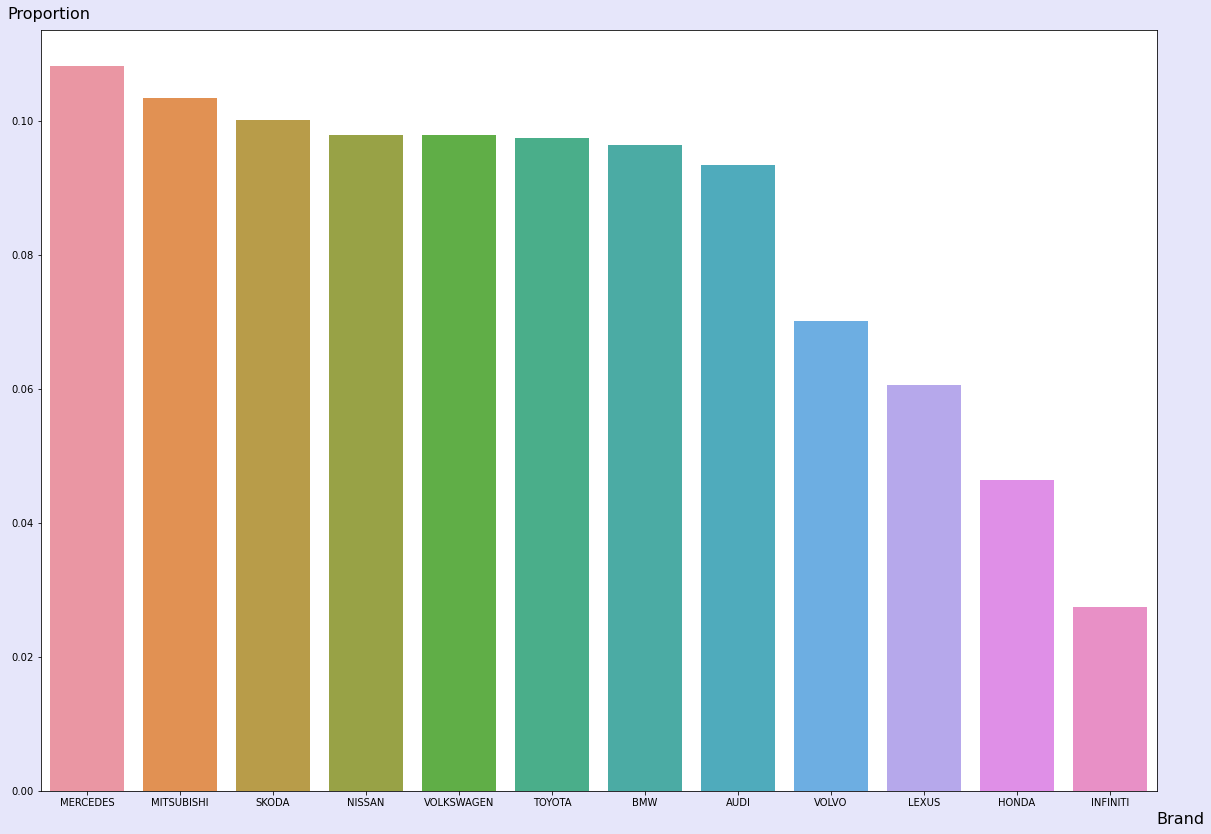

In [37]:
data_size = len(train) # Длина набора.

# Расчёт в долях.
brand = train.brand.value_counts().reset_index().rename({'index': 'Brand', 'brand': 'count'}, axis=1)
brand['count'] = brand['count'].apply(lambda x: x / data_size)
brand_val = brand['Brand'].values

# Построение гистограммы
fig, ax = plt.subplots(figsize=(20, 14), facecolor="Lavender")
# Бренды
sns.barplot(x='Brand', y='count', data=brand, ci=None, orient='v',  ax=ax, order=brand_val);
ax.set_xlabel('Brand', rotation=0, position=(1, 1.01), ha='left', fontsize=16);
ax.set_ylabel('Proportion', rotation=0, position=(0, 1.01), ha='left', fontsize=16);

Сравнивая с графиком из первой работы, видно, что не добрали для BMW.. Возможная причина, слишком мало объявлений обрабатывали, надо было больший период времени выбирать, чтобы набор был более сбалансированным. Но увы, на это уже нет времени. В целом не сильно BMW снизился.

Будем работать с этим набором.

## 2.2. Объединение Таблиц.

Крайне важно, чтобы данные таблиц теста и трейна были одного типа.
Загрузим тестовый набор.

In [38]:
# Загружаем тест.
test = pd.read_csv(INPUT_PATH+'test.csv');

In [39]:
# Посмотрим на его колонки.
print(f'Столбцы тренировчного набора: {[col for col in test.columns]}')
print(f'Их количество: {len(test.columns)}')

Столбцы тренеровчного набора: ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
Их количество: 32


Ну что ж, удалим лишние столбцы "index", "Unnamed: 0", "Unnamed: 0.1", "location".

In [40]:
# Удаляем лишние столбцы.
train.drop(['index', "Unnamed: 0", "Unnamed: 0.1", 'location'], axis=1, inplace=True)

In [41]:
# Сколько осталось столбцов и каких в тренировочном наборе.
print(f'Столбцы тренировчного набора: {[col for col in train.columns]}')
print(f'Их количество: {train.shape[1]}')

Столбцы тренеровчного набора: ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'price']
Их количество: 33


Проверим ещё раз на типы данных в тестовом наборе. Всё в норме, + 1 это цена в трейне.

In [42]:
# Делаем копию датасета.
df = test.copy();
df = df.apply(data_type)

# Посмотрим, что получилось
df.head(10)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
1,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
2,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
3,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
4,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
5,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
6,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
7,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'float'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>
8,<class 'str'>,<class 'str'>,

Флоаты в строках со стрингами это наны, так что всё в норме.

Объединяем.

In [43]:
# Новые признаки для наборов, чтоб можно было отличать их.
train['Train'] = 1 # Тренировочный набор.
test['Train' ] = 0 # Тестовый набор.

# Для быстро и удобной обработки признаков объединяем оба набора в один датасэт.
data = train.append(test, sort=False).reset_index(drop=True) # Женим..

# Проверяем, что получилось.
data.sample(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,Train
48098,лифтбек,SKODA,https://auto.ru/cars/new/sale/skoda/superb/110...,коричневый,"{'id': '21684964', 'name': 'Ambition', 'availa...",➽ Автомир Богемия Дмитровка | Официальный диле...,2.0 LTR,190 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/470651...,0,2019,"{'code': 'SUPERB', 'name': 'Superb', 'ru_name'...",Superb,2.0d AMT (190 л.с.),5,1624239081000,RUB,2021,1103998009-8ce9dda2,"{'id': '21619712', 'name': 'III Рестайлинг', '...",LIFTBACK ROBOT 2.0,роботизированная,EUROPEAN,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,3020000.0,1
62277,хэтчбек 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/tiida/11...,серый,NaN,Авто в хорошем состоянии. Масло и фильтры миня...,1.6 LTR,110 N12,NaN,бензин,https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...,185932,2004,"{""code"":""TIIDA"",""name"":""Tiida"",""ru_name"":""Тиид...",TIIDA,1.6 MT (110 л.с.),5,1603280119,RUB,2007,1101301776,"{""id"":""7896254"",""displacement"":1598,""engine_ty...",HATCHBACK_5_DOORS MECHANICAL 1.6,механическая,JAPANESE,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,NaN,0
72636,компактвэн,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tour...,чёрный,NaN,"Хорошее состояние, честный пробег.\n",1.4 LTR,140 N12,"{""asr"":true,""tinted-glass"":true,""esp"":true,""ai...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,152000,2010,"{""code"":""TOURAN"",""name"":""Touran"",""ru_name"":""Ту...",TOURAN,1.4 AMT (140 л.с.),5,1603216797,RUB,2011,1101104736,"{""id"":""20495000"",""displacement"":1390,""engine_t...",COMPACTVAN ROBOT 1.4,роботизированная,EUROPEAN,2 владельца,1 год,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,0
40230,лифтбек,SKODA,https://auto.ru/cars/new/sale/skoda/rapid/1104...,белый,"{'id': '22128588', 'name': 'Ambition', 'availa...",Специальные предложения на автомобили в наличи...,1.6 LTR,90 N12,"{'cruise-control': True, 'glonass': True, 'esp...",бензин,//avatars.mds.yandex.net/get-autoru-vos/535879...,0,2020,"{'code': 'RAPID', 'name': 'Rapid', 'ru_name': ...",Rapid,1.6 MT (90 л.с.),5,1630918772000,RUB,2021,1104778064-40a856dc,"{'id': '21738448', 'name': 'II', 'ru_name': '2...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,NaN,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1750000.0,1
58621,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x3/10955824...,синий,"{""id"":""7150211"",""name"":""xDrive28i Lifestyle"",""...","Великолепное состояние, косметическое и технич...",2.0 LTR,245 N12,"{""cruise-control"":true,""esp"":true,""multi-wheel...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,104000,2010,"{""code"":""X3"",""name"":""X3"",""ru_name"":""Х3"",""morph...",X3,28i xDrive 2.0 AT (245 л.с.) 4WD,5,1603118223,RUB,2014,1095582408,"{""id"":""7957949"",""name"":""28i"",""nameplate"":""28i ...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,3 года и 8 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,NaN,0


Вспомним, что в тестовом наборе 24 типа кузова, когда в трейне - 22. Посмотрим на них.

In [44]:
data[data.Train==0].bodyType.unique() # Тестовый набор.

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [45]:
data[data.Train==1].bodyType.unique() # Тренировочный набор.

array(['внедорожник 5 дв.', 'хэтчбек 3 дв.', 'универсал 5 дв.', 'седан',
       'хэтчбек 5 дв.', 'минивэн', 'купе-хардтоп', 'купе', 'лифтбек',
       'фургон', 'пикап полуторная кабина', 'компактвэн',
       'пикап двойная кабина', 'внедорожник 3 дв.',
       'пикап одинарная кабина', 'кабриолет', 'микровэн', 'родстер',
       'седан-хардтоп', 'седан 2 дв.', 'лимузин', 'внедорожник открытый'],
      dtype=object)

Получается, что нам не хватает тарги и фастбека. Что это? Фастбек это тип кузова, который сейчас чаще всего ассоциируется с хэтчбеком, а тарга - с кабриолетом. Давайте приведём к общему знаменателю.

In [46]:
data[data.bodyType=='фастбек'] # Посмотрим на фастбек.

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,Train
60161,фастбек,NISSAN,https://auto.ru/cars/used/sale/nissan/280zx/10...,серебристый,NaN,"Легендарное спорт купе Ниссан 280zx, выпущен в...",2.8 LTR,145 N12,NaN,бензин,https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...,2000,1978,"{""code"":""280ZX"",""name"":""280ZX"",""ru_name"":""280Z...",280ZX,2.8 MT (145 л.с.),3,1603272088,RUB,1980,1099081002,"{""id"":""20471531"",""displacement"":2753,""engine_t...",FASTBACK MECHANICAL 2.8,механическая,JAPANESE,2 владельца,NaN,Дубликат,задний,Правый,Не требует ремонта,Растаможен,NaN,0


In [47]:
data[data.bodyType=='тарга'] # Посмотрим на таргу.

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,Train
60649,тарга,NISSAN,https://auto.ru/cars/used/sale/nissan/100nx/11...,красный,NaN,Спортивный автомобиль для любителей японской с...,1.6 LTR,90 N12,"{""alloy-wheel-disks"":true,""audiosystem-cd"":tru...",бензин,https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...,206303,1990,"{""code"":""100NX"",""name"":""100NX"",""ru_name"":""100N...",100NX,1.6 MT (90 л.с.),2,1603273958,RUB,1992,1100063912,"{""id"":""21802861"",""displacement"":1597,""engine_t...",TARGA MECHANICAL 1.6,механическая,JAPANESE,2 владельца,2 года,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN,0
69952,тарга,TOYOTA,https://auto.ru/cars/used/sale/toyota/mr2/1083...,пурпурный,NaN,"Куплен авто 28 августа 2018.\n\nПродаю, не изб...",2.0 LTR,170 N12,"{""driver-seat-support"":true,""leather-gear-stic...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,100000,1989,"{""code"":""MR2"",""name"":""MR2"",""ru_name"":""МР 2"",""m...",MR2,2.0 MT (170 л.с.),2,1603295968,RUB,1991,1083551469,"{""id"":""20464708"",""displacement"":1998,""engine_t...",TARGA MECHANICAL 2.0,механическая,JAPANESE,3 или более,2 года и 2 месяца,Оригинал,задний,Правый,Не требует ремонта,Растаможен,NaN,0


Не так и много, изменим наименования кузова, как для большинства.

In [48]:
# Меняем названия.
data.loc[data.bodyType == 'фастбек', 'bodyType'] = 'хэтчбек 3 дв.'
data.loc[data.bodyType == 'тарга', 'bodyType'] = 'кабриолет'

# Посмотрим ещё раз.
print(f'Количество уникальных значений: {data.bodyType.nunique()}')
print('Уникальные значения.')
data.bodyType.unique()

Количество уникальных значений: 22
Уникальные значения.


array(['внедорожник 5 дв.', 'хэтчбек 3 дв.', 'универсал 5 дв.', 'седан',
       'хэтчбек 5 дв.', 'минивэн', 'купе-хардтоп', 'купе', 'лифтбек',
       'фургон', 'пикап полуторная кабина', 'компактвэн',
       'пикап двойная кабина', 'внедорожник 3 дв.',
       'пикап одинарная кабина', 'кабриолет', 'микровэн', 'родстер',
       'седан-хардтоп', 'седан 2 дв.', 'лимузин', 'внедорожник открытый'],
      dtype=object)

In [49]:
# Сохраняем наш набор.
data.to_csv(INPUT_PATH+'cut_train.csv')

In [50]:
#data = pd.read_csv(INPUT_PATH+'cut_train.csv')

In [51]:
# Проверим, более подробно.
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83083 entries, 0 to 83082
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              83083 non-null  object 
 1   brand                 83083 non-null  object 
 2   car_url               83083 non-null  object 
 3   color                 83083 non-null  object 
 4   complectation_dict    54815 non-null  object 
 5   description           81843 non-null  object 
 6   engineDisplacement    83083 non-null  object 
 7   enginePower           83083 non-null  object 
 8   equipment_dict        73087 non-null  object 
 9   fuelType              83083 non-null  object 
 10  image                 83083 non-null  object 
 11  mileage               83083 non-null  int64  
 12  modelDate             83083 non-null  int64  
 13  model_info            83083 non-null  object 
 14  model_name            83083 non-null  object 
 15  name               

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,price,Train
count,8.308300e+04,83083.000000,83083.000000,8.308300e+04,83083.000000,4.839700e+04,83083.000000
mean,1.358748e+05,2009.599184,4.547091,9.495272e+11,2011.769411,2.671882e+06,0.582514
std,1.078787e+05,7.773330,0.664960,8.025439e+11,7.498913,3.005312e+06,0.493147
min,0.000000e+00,1904.000000,0.000000,1.603107e+09,1904.000000,3.000000e+04,0.000000
25%,5.041650e+04,2006.000000,4.000000,1.603270e+09,2008.000000,8.600000e+05,0.000000
50%,1.250000e+05,2011.000000,5.000000,1.626207e+12,2013.000000,1.770000e+06,1.000000
75%,1.980000e+05,2015.000000,5.000000,1.632412e+12,2017.000000,3.360000e+06,1.000000
max,1.190000e+06,2021.000000,5.000000,1.633226e+12,2021.000000,5.130000e+07,1.000000


In [52]:
data.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,Train
0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1104...,синий,"{'id': '20013525', 'name': 'Executive (5 мест)...",В нашем автосалоне Вы можете автомобиль - купи...,2.4 LTR,163 N12,"{'cruise-control': True, 'esp': True, 'usb': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/356459...,274000,2006,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.4d MT (163 л.с.) 4WD,5,1633157084000,RUB,2010,1104248897-2c4e63f6,"{'id': '2310047', 'name': 'I Рестайлинг', 'ru_...",ALLROAD_5_DOORS MECHANICAL 2.4,механическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1110000.0,1
1,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/new/sale/volvo/xc60/11047...,чёрный,"{'id': '22174038', 'name': 'Momentum', 'availa...",Узнайте вашу выгоду на автомобили VOLVO в Inch...,2.0 LTR,235 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/523445...,0,2017,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.0d AT (235 л.с.) 4WD,5,1627479445000,RUB,2021,1104737585-9b835e4b,"{'id': '20950306', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5300000.0,1
2,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/new/sale/volvo/xc60/11047...,чёрный,"{'id': '22174500', 'name': 'Inscription', 'ava...",Узнайте вашу выгоду на автомобили VOLVO в Inch...,2.0 LTR,190 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/523227...,0,2017,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.0d MT (190 л.с.) 4WD,5,1627472315000,RUB,2021,1104737644-e72a63a3,"{'id': '20950306', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS MECHANICAL 2.0,механическая,EUROPEAN,NaN,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5330000.0,1
3,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1105...,чёрный,"{'id': '22174038', 'name': 'Momentum', 'availa...",💸Выгода до 100 000 рублей при покупке в кредит...,2.0 LTR,190 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,//avatars.mds.yandex.net/get-autoru-vos/528963...,27000,2017,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.0 AT (190 л.с.),5,1633156097000,RUB,2020,1105077546-8866490f,"{'id': '20950306', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,3820000.0,1
4,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1105...,белый,"{'id': '0', 'name': ''}",Автомобили с пробегом от Официального Дилера У...,2.4 LTR,220 N12,"{'tinted-glass': True, 'airbag-driver': True, ...",дизель,//avatars.mds.yandex.net/get-autoru-vos/515126...,114000,2013,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.4d AT (220 л.с.) 4WD,5,1633157064000,RUB,2014,1105477413-6b6e32cd,"{'id': '20012324', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1890000.0,1


Ещё раз посмотрим на пропуски.

	Пропуски тренеровочного набора


bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description              1240
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы               18624
Владение                60937
ПТС                       414
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
price                   34686
Train     

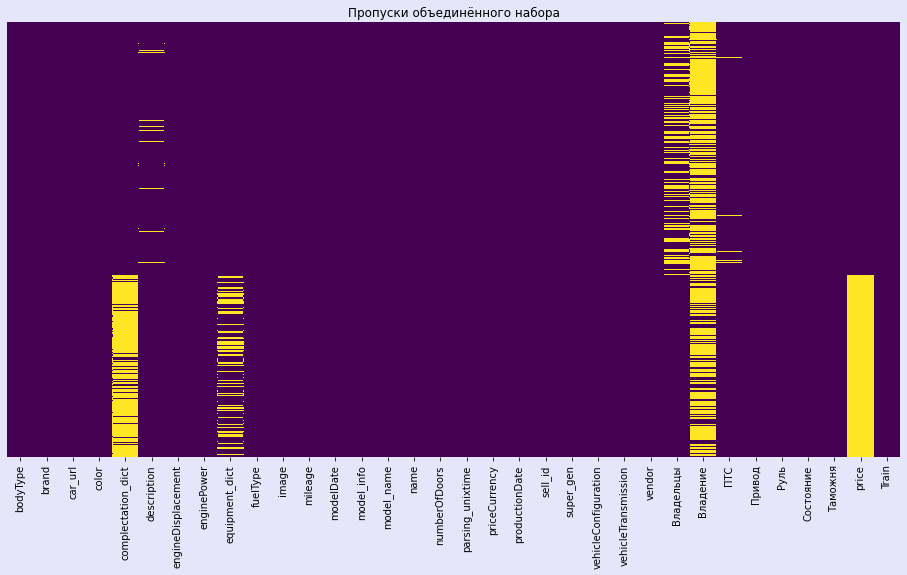

In [53]:
# Проверим и визуализируем пропуски набора.
print('\tПропуски тренировочного набора')
display(data.isnull().sum())  # Общий набор.

# Визуализируем пропуски.
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap="viridis", ax=ax);

# Подписываем.
ax.set_title("Пропуски объединённого набора");

In [54]:
# Посмотрим, что там с ПТС.
data['ПТС'].value_counts()

Оригинал    73087
Дубликат     9582
Name: ПТС, dtype: int64

In [55]:
# Так как наиболее часто ПТС это оригинал, заменим им пропуки.
data.loc[data.ПТС.isna(),'ПТС'] = 'Оригинал'

Самое простое починили. Остальное такое как "Владельцы", "Владение", комплектацию починить будет сложно. Но мы попобруем.

## 2.3 Обработка пропусков.

### Признак "Владельцы".

In [56]:
# Посмотрим на статистику по владельцам.
df = data[data['Train']==1]                    # Проблемы только с тренировочным набором.
df['Владельцы'].value_counts() # Смотрим.

1 владелец     12355
2 владельца     9677
3 или более     7741
Name: Владельцы, dtype: int64

То есть нет особой сильной доминанты. А заполнить надо много.
В целом очень жаль его удалять. Из него вполне можно было сделать числовой или категориальный признак. Я пытался привязаться с этим столбцом к другим признакам. Тестов было много. Лучше всех себя показала его связь с годом выпуска. Смотрим.

In [57]:
# Покажем что у нас по годам.
df.loc[df['Владельцы'].isna()].productionDate.head(10)

1     2021
2     2021
5     2011
8     2021
9     2008
10    2021
11    2012
14    2021
20    2021
22    2011
Name: productionDate, dtype: int64

In [58]:
# Более подробно с валуе_каунтс.
df.loc[df['Владельцы'].isna()].productionDate.value_counts(normalize=True)

2021    0.591226
2008    0.040056
2007    0.032485
2011    0.026579
2006    0.024216
2012    0.023142
2010    0.021692
2005    0.018686
2013    0.018363
2004    0.017236
2014    0.014659
2003    0.014122
1998    0.014068
2001    0.012994
2002    0.012564
2000    0.012511
2009    0.012350
2015    0.011866
1999    0.011329
1997    0.010470
1996    0.007195
2020    0.007195
2016    0.006604
1993    0.005155
1994    0.004618
1992    0.004349
1995    0.003920
1991    0.003598
2017    0.003436
1990    0.002577
2018    0.002524
1989    0.001987
1988    0.001503
1987    0.001128
2019    0.001074
1986    0.000644
1983    0.000430
1985    0.000430
1984    0.000430
1982    0.000215
1979    0.000161
1970    0.000054
1977    0.000054
1975    0.000054
1978    0.000054
Name: productionDate, dtype: float64

То есть это в большинстве своём это новые автомобили! И значит у них 0 владельцев. Воспользуемся этим и сделаем его категориальным признаком.

In [59]:
# Обновляем столбец "Владельцы" и делаем его категориальным.
# Словарь.
owners_dict = {'3 или более':3, '2\xa0владельца':2, '1\xa0владелец':1}

# Делаем замену.
data['Владельцы'] = data['Владельцы'].map(owners_dict)

# Побеждаем наны.
data['Владельцы'].fillna(0, inplace=True)

# Преобразуем к инт.
data['Владельцы'] = data['Владельцы'].astype(int)

# Проверим, что получилось.
data['Владельцы'].value_counts()

3    23698
1    21814
2    18947
0    18624
Name: Владельцы, dtype: int64

### Признак "Владение".

In [60]:
# Провернём ещё раз тот же механизм для трейна.
df = data[data['Train']==1]
df.loc[df['Владение'].isna()].productionDate.value_counts(normalize=True).head(5)

2021    0.300031
2018    0.053993
2012    0.052293
2013    0.051169
2014    0.050567
Name: productionDate, dtype: float64

In [61]:
# Провернём ещё раз тот же механизм для теста.
df = data[data['Train']==0]
df.loc[df['Владение'].isna()].productionDate.value_counts(normalize=True).head(5)

2012    0.080428
2011    0.074347
2013    0.072628
2008    0.072319
2014    0.063373
Name: productionDate, dtype: float64

Скорее всего не получится, так как уже тут нет такой доминанты.

Посмотрим ещё раз на этот столбец.

In [62]:
# Посмотрим какие они эти данные в начале.
data['Владение'].head(20)

0                             NaN
1                             NaN
2                             NaN
3                             NaN
4                             NaN
5                             NaN
6                             NaN
7                             NaN
8                             NaN
9                             NaN
10                            NaN
11                            NaN
12                            NaN
13    {'year': 2017, 'month': 11}
14                            NaN
15                            NaN
16                            NaN
17                            NaN
18                            NaN
19                            NaN
Name: Владение, dtype: object

In [63]:
# И в конце.
data['Владение'].tail(5)

83078    2 года и 1 месяц
83079                 NaN
83080                 NaN
83081                 NaN
83082     6 лет и 1 месяц
Name: Владение, dtype: object

Представление по разному: в тесте этот столбец даёт ответ на вопрос сколько, когда в трейне - когда попала к хозяину, приведём всё в один вид.

In [64]:
#заполняем пропуски значением nodata
data['Владение'] = data['Владение'].fillna('nodata')
data.loc[data['Train']==1,'Владение'] = data[data['Train']==1]['Владение'].apply(vl_parsing)
data['Владение'] = data['Владение'].fillna('nodata')

In [65]:
data['Владение'].value_counts()

nodata                60937
9 месяцев               611
8 месяцев               547
7 месяцев               522
10 месяцев              512
                      ...  
19 лет и 4 месяца         1
30 лет и 2 месяца         1
27 лет и 3 месяца         1
16 лет и 5 месяцев        1
20 лет                    1
Name: Владение, Length: 340, dtype: int64

In [66]:
# Добавим ещё один признак количества месяцев владения.
data['num_of_month'] = data['Владение'].apply(get_months_count)

Разумно предположить, что если нет данных по этому столбцу, то владение началось в тот же год, что и дата выпуска. Такова моя гипотеза.

In [67]:
# Заменим все наны выражением.
data['num_of_month'] = data['num_of_month'].fillna(12*(2021-data['productionDate']))

In [68]:
# Что получилось?
data['num_of_month']

0        132.0
1          0.0
2          0.0
3         12.0
4         84.0
         ...  
83078     25.0
83079     36.0
83080    288.0
83081     96.0
83082     73.0
Name: num_of_month, Length: 83083, dtype: float64

In [69]:
# Приведём к целому типу.
data.num_of_month = data.num_of_month.astype(int)

In [70]:
data.head(2) # Посмотрим, что вышло.

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,Train,num_of_month
0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1104...,синий,"{'id': '20013525', 'name': 'Executive (5 мест)...",В нашем автосалоне Вы можете автомобиль - купи...,2.4 LTR,163 N12,"{'cruise-control': True, 'esp': True, 'usb': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/356459...,274000,2006,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.4d MT (163 л.с.) 4WD,5,1633157084000,RUB,2010,1104248897-2c4e63f6,"{'id': '2310047', 'name': 'I Рестайлинг', 'ru_...",ALLROAD_5_DOORS MECHANICAL 2.4,механическая,EUROPEAN,2,nodata,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1110000.0,1,132
1,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/new/sale/volvo/xc60/11047...,чёрный,"{'id': '22174038', 'name': 'Momentum', 'availa...",Узнайте вашу выгоду на автомобили VOLVO в Inch...,2.0 LTR,235 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/523445...,0,2017,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.0d AT (235 л.с.) 4WD,5,1627479445000,RUB,2021,1104737585-9b835e4b,"{'id': '20950306', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,0,nodata,Оригинал,полный,Левый,Не требует ремонта,Растаможен,5300000.0,1,0


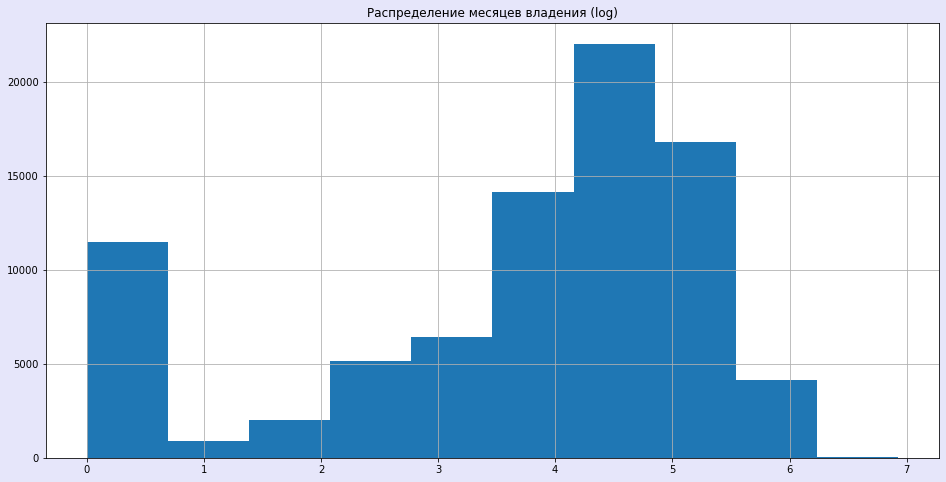

In [71]:
# И посмотрим гистограмму.
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
data.num_of_month.apply(lambda x: np.log(1+x)).hist(ax=ax)

# Подписываем.
ax.set_title("Распределение месяцев владения (log)");

Возможно это была плохая идея, привязаться к году выпуска. Но что ж..

In [72]:
# Имеет смысл оставить в логарифмическом масштабе.
#data.num_of_month = data.num_of_month.apply(np.log)

Собственно, этот столбец мы по другому победили, я ввёл новый признак - количество месяцев владения авто. Сам этот "Владение" признак можно упразднять.

In [73]:
# Посмотрим какие характеристики.
data.num_of_month.describe()

count    83083.000000
mean        87.130147
std         84.261589
min          0.000000
25%         19.000000
50%         72.000000
75%        132.000000
max       1020.000000
Name: num_of_month, dtype: float64

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83083 entries, 0 to 83082
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              83083 non-null  object 
 1   brand                 83083 non-null  object 
 2   car_url               83083 non-null  object 
 3   color                 83083 non-null  object 
 4   complectation_dict    54815 non-null  object 
 5   description           81843 non-null  object 
 6   engineDisplacement    83083 non-null  object 
 7   enginePower           83083 non-null  object 
 8   equipment_dict        73087 non-null  object 
 9   fuelType              83083 non-null  object 
 10  image                 83083 non-null  object 
 11  mileage               83083 non-null  int64  
 12  modelDate             83083 non-null  int64  
 13  model_info            83083 non-null  object 
 14  model_name            83083 non-null  object 
 15  name               

### Признак "engineDisplacement".

Проверим на пропуски данный признак.

In [75]:
# Посмотрим какие бывают литражи.
data.engineDisplacement.value_counts()

2.0 LTR    21462
1.6 LTR     9957
3.0 LTR     9639
1.8 LTR     5153
2.5 LTR     5019
3.5 LTR     4241
2.4 LTR     4025
1.4 LTR     3750
1.5 LTR     2254
4.0 LTR     1437
1.2 LTR     1238
1.9 LTR     1177
4.4 LTR     1019
1.3 LTR      928
2.1 LTR      779
3.2 LTR      749
2.2 LTR      742
2.8 LTR      716
2.9 LTR      693
4.7 LTR      677
4.5 LTR      668
2.7 LTR      635
5.5 LTR      595
2.3 LTR      527
5.7 LTR      514
5.6 LTR      469
3.7 LTR      444
4.2 LTR      415
1.0 LTR      360
5.0 LTR      357
4.6 LTR      330
3.6 LTR      319
1.7 LTR      183
3.3 LTR      176
6.0 LTR      150
4.1 LTR      129
3.1 LTR      127
4.8 LTR      125
0.7 LTR      119
0.0 LTR      109
3.8 LTR      107
4.3 LTR       95
2.6 LTR       84
3.4 LTR       79
6.2 LTR       64
 LTR          55
5.4 LTR       46
5.9 LTR       26
4.9 LTR       24
0.6 LTR       20
6.3 LTR       20
5.2 LTR       17
6.6 LTR       15
1.1 LTR       11
5.8 LTR        7
3.9 LTR        6
5.3 LTR        1
Name: engineDisplacement, dtype

In [76]:
# Есть интересный литраж просто " LTR", проверим.
data[data.engineDisplacement==' LTR'].fuelType.value_counts()

электро    55
Name: fuelType, dtype: int64

Отлично, это электро кары. Посмотрим, что для них ставят обычно.

In [77]:
# Проверяем электро кары.
data[data.fuelType=='электро'].engineDisplacement.value_counts()

0.0 LTR    109
 LTR        55
Name: engineDisplacement, dtype: int64

Ставят 0 кубиков. Так мы и поступим. Но сначала приведём все кубики к нужному типу.

In [78]:
# Сначала проверим, какие бывают литражи.
data.engineDisplacement.unique()

array(['2.4 LTR', '2.0 LTR', '1.6 LTR', '2.5 LTR', '3.0 LTR', '3.5 LTR',
       '1.9 LTR', '5.5 LTR', '2.9 LTR', '2.1 LTR', '4.0 LTR', '1.3 LTR',
       '6.0 LTR', '4.7 LTR', '4.1 LTR', '0.6 LTR', '4.8 LTR', '4.4 LTR',
       '4.5 LTR', '2.7 LTR', '3.3 LTR', '2.2 LTR', '1.8 LTR', '4.6 LTR',
       '1.5 LTR', '2.8 LTR', '1.4 LTR', '3.6 LTR', '4.2 LTR', '5.6 LTR',
       '3.2 LTR', '2.3 LTR', '1.2 LTR', '1.0 LTR', '1.7 LTR', '3.8 LTR',
       '5.7 LTR', '3.1 LTR', '5.4 LTR', '3.4 LTR', '5.0 LTR', '3.7 LTR',
       '0.0 LTR', '2.6 LTR', '4.3 LTR', '0.7 LTR', '1.1 LTR', '6.3 LTR',
       '6.6 LTR', '6.2 LTR', '5.9 LTR', '4.9 LTR', '3.9 LTR', '5.2 LTR',
       ' LTR', '5.8 LTR', '5.3 LTR'], dtype=object)

In [79]:
# Приводим в нужный вид.
data.engineDisplacement = data.engineDisplacement.apply(ed_volume)
# Проверяем, что вышло.
data.engineDisplacement.sample(5)

1164     1400.0
35263    2000.0
17204    2000.0
42124    4500.0
32203    3000.0
Name: engineDisplacement, dtype: float64

<AxesSubplot:title={'center':'Распределение объёма двигателя'}>

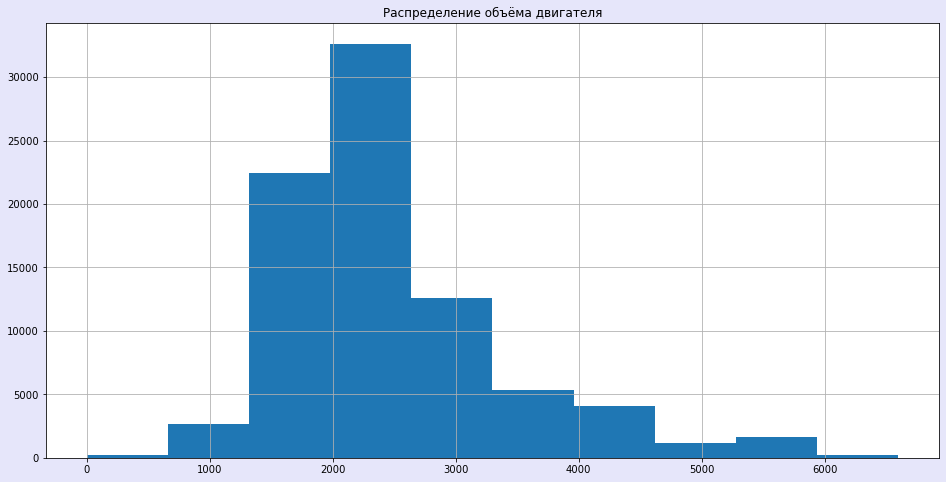

In [80]:
# Посмотрим на распределение.
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")

# Подписываем.
ax.set_title("Распределение объёма двигателя");
data.engineDisplacement.hist(ax=ax)

Распредление выглядит вполне хорошо. В основном это 2 - 3 литра, что близко к жизни.

### Признак "enginePower".

In [81]:
# Посмотрим, что у нас в мощности.
data.enginePower.head()

0    163 N12
1    235 N12
2    190 N12
3    190 N12
4    220 N12
Name: enginePower, dtype: object

In [82]:
# Преобразуем этот столбец.
data.enginePower = data.enginePower.str.replace('N12','').astype(float)

# Посмотрим, что получилось.
data.enginePower.sample(10)

30143    177.0
8067     270.0
70251    167.0
15663    231.0
59828    144.0
41055    121.0
38966    150.0
63579    280.0
66509    245.0
77743    184.0
Name: enginePower, dtype: float64

<AxesSubplot:title={'center':'Распределение мощности двигателя'}>

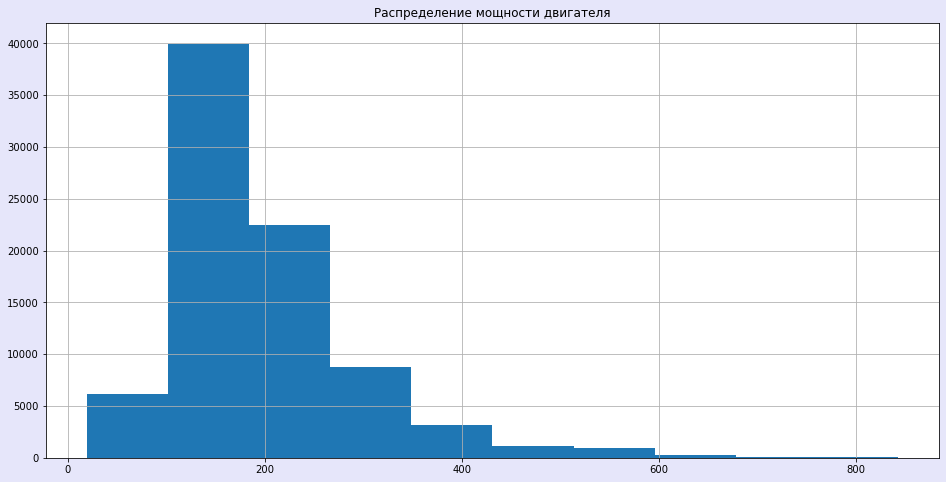

In [83]:
# Посмотрим на распределение.
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")

# Подписываем.
ax.set_title("Распределение мощности двигателя");
data.enginePower.hist(ax=ax)

Здесь так же можно сказать, что в основном машины где-то впределе 200 лошадиных сил. Дальше налоги дают знать.

### Признак "equipment_dict".

Данное поле содержит себе словарь с опициями по авто.

In [84]:
# Рассмотрим пример.
data.equipment_dict.sample(2).values

array([nan,
       "{'cruise-control': True, 'start-stop-function': True, 'esp': True, 'airbag-driver': True, 'usb': True, 'isofix': True, 'electro-window-front': True, 'light-sensor': True, 'hcc': True, 'multi-wheel': True, 'xenon': True, 'automatic-lighting-control': True, 'ashtray-and-cigarette-lighter': True, 'airbag-curtain': True, 'airbag-passenger': True, 'front-centre-armrest': True, 'computer': True, 'passenger-seat-electric': True, 'lock': True, 'light-cleaner': True, 'door-sill-panel': True, 'servo': True, 'fabric-seats': True, 'electro-mirrors': True, 'electro-window-back': True, 'start-button': True, 'ptf': True, 'rain-sensor': True, 'airbag-side': True, 'mirrors-heat': True, '17-inch-wheels': True, 'audiosystem-cd': True, 'park-assist-f': True, 'wheel-heat': True, 'abs': True, 'front-seats-heat': True, 'bluetooth': True, 'wheel-configuration2': True, 'wheel-leather': True, 'wheel-configuration1': True, 'immo': True, 'climate-control-1': True, '12v-socket': True, 'park-ass

То есть, что мы видим: набор опций и их значение в виде True или False, в зависимости от наличия их в автомобиле.

In [85]:
eq_df = create_df(data, 'equipment_dict')
eq_df.fillna(False, inplace=True)
eq_df.head()

,cruise-control,esp,usb,windcleaner-heat,multi-wheel,xenon,heated-wash-system,airbag-passenger,roof-rails,lock,electro-mirrors,electro-window-back,18-inch-wheels,mirrors-heat,volume-sensor,body-mouldings,rear-seats-heat,leather,seat-memory,music-super,park-assist-r,engine-proof,front-seats-heat-vent,airbag-driver,isofix,aux,electro-window-front,light-sensor,automatic-lighting-control,airbag-curtain,passenger-seat-updown,collision-prevention-assist,computer,seat-transformation,wheel-power,alarm,passenger-seat-electric,light-cleaner,dha,alloy-wheel-disks,ptf,leather-gear-stick,rain-sensor,airbag-side,seats-5,tyre-pressure,migration-flag,abs,front-seats-heat,wheel-configuration2,wheel-leather,wheel-configuration1,immo,light-interior,climate-control-2,auto-mirrors,12v-socket,third-rear-headrest,asr,audiosystem-tv,lane-keeping-assist,front-centre-armrest,navigation,bas,rear-camera,door-sill-panel,servo,drl,park-assist-f,wheel-heat,led-lights,glonass,start-stop-function,drive-mode-sys,hcc,high-beam-assist,keyless-entry,driver-seat-electric,fabric-seats,traffic-sign-recognition,voice-recognition,electronic-gage-panel,electro-trunk,bluetooth,windscreen-heat,front-seat-support,decorative-interior-lighting,easy-trunk-opening,19-inch-wheels,start-button,reduce-spare-wheel,driver-seat-memory,tinted-glass,audiopreparation,airbag-rear-side,17-inch-wheels,climate-control-1,knee-airbag,feedback-alarm,remote-engine-start,audiosystem-cd,dark-interior,e-adjustment-wheel,paint-metallic,blind-spot,massage-seats,auto-cruise,20-inch-wheels,hatch,panorama-roof,power-child-locks-rear-doors,seats-2,adaptive-light,programmed-block-heater,auto-park,220v-socket,drowsy-driver-alert-system,android-auto,seats-7,third-row-seats,black-roof,ashtray-and-cigarette-lighter,apple-carplay,air-suspension,steering-wheel-gear-shift-paddles,multizone-climate-control,roller-blinds-for-rear-side-windows,projection-display,360-camera,combo-interior,laminated-safety-glass,wheel-memory,cooling-box,folding-front-passenger-seat,wireless-charger,16-inch-wheels,spare-wheel,isofix-front,driver-seat-updown,sport-seats,sport-pedals,body-kit,sport-suspension,electro-rear-seat,driver-seat-support,eco-leather,seats-6,218,345,440,632,873,airbrush,entertainment-system-for-rear-seat-passengers,500,activ-suspension,51U,234,401,443,810,872,21-inch-wheels,power-latching-doors,velvet-seats,228,22-inch-wheels,laser-lights,vsm,roller-blind-for-rear-window,rear-seat-heat-vent,540,597,881,rear-seat-memory,U25,turnbuckle,840,steel-wheels,condition,adj-pedals,alcantara,rcta,15-inch-wheels,gbo,night-vision,folding-tables-rear,seats-4,ya-auto,12-inch-wheels,seats-8,14-inch-wheels,61U,301,seats-9,front-camera,duo-body-color,608,armored,dual-xenon,23-inch-wheels,13-inch-wheels,4D3,9VS,6NQ,8X1,3S1,8T2,24-inch-wheels,seats-heat,electro-window-all,electro-seat,parktronik,airbag-4,advanced-frontlighting-system,driver-seat-manual,halogen,airbag-7,airbag-2,airbag-1,passenger-seat-memory,climate-control,immobiliser-not-standard,wheel-configuration3,28-inch-wheels,passenger-seat-manual,PX2,KA2,3L5,6XF,N4M,climate-control-3,airbag-8,313,414,27-inch-wheels,F62,6E3,4A3,F48,9R1,3FB,PE6,8RF,8RM,239,7X5,357,audiosystem,PCH,PW1,8T6,PL2,9S6,9P5,RAB,PN0,PB0,6XE,PNQ,airbag-6,25-inch-wheels,235,242,246,249,270,274,351,364,367,431,448,475,501,513,551,670,728,772,776,807,824,871,882,883,889,927,989,U09,H06,U22,DZ9,P17,B63,RVR,14U,R66,P29,03B,P31,16U,P44,R01,B16,17U,L5C,WVA,S7N,E0P,2C5,1N1,7AA,9AB,UI4,6XD,3B3,7B2,9S3,4I2,3NZ,4UC,4UE,4R2,4R3,6R1,9T1,3Q6
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

Что мы тут видим. Круиз контроль, есп, юсб, ксенон, подушки безопасности, электропривод зеркал, электростеклоподъёмники и прочее. В целом за это в салоне приходится доплачивать, и данные опции могут сильно повлиять на цену. Полагаю, что это довольно важные параметры. Надеюсь, в дальнейшем они нам понадобятся.

### Признак "complectation_dict".

Данный признак содержит словарь информацию по комплектации.
Посмотрим на него.

In [86]:
# Рассмотрим пример.
data.complectation_dict.sample(2).values

array(["{'id': '0', 'name': ''}",
       '{"id":"2406341","name":"Комфорт","available_options":["airbag-passenger","lock","electro-mirrors","mirrors-heat","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","climate-control-1","audiopreparation","electro-window-back","condition","airbag-driver","electro-window-front","alarm","ptf","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}'],
      dtype=object)

Как мы видим, данный признак довольно таки хорошо перекликается с предыдущим.

In [87]:
# Распарсим его, и посмотрим в более привычном виде.
co_df = create_df(data, 'complectation_dict')
co_df.fillna(False, inplace=True)
co_df.head()

,id,name,available_options,vendor_colors
0,20013525,Executive (5 мест),"[cruise-control, multi-wheel, airbag-passenger...",False
1,22174038,Momentum,"[cruise-control, multi-wheel, airbag-passenger...",False
2,22174500,Inscription,"[cruise-control, multi-wheel, airbag-passenger...",False
3,22174038,Momentum,"[cruise-control, multi-wheel, airbag-passenger...",False
4,0,,False,False


То есть по сути повторение equipment_dict.

### Признак "super_gen".

Распарсим его, как предыдущие.

In [88]:
# Распарсим его, и посмотрим в более привычном виде.
sg_df = create_df(data, 'super_gen')
sg_df.fillna(False, inplace=True)
sg_df.head()

,id,name,ru_name,year_from,year_to,price_segment,purpose_group,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max
0,2310047,I Рестайлинг,1 Рестайлинг,2006,2014,PREMIUM,BUSINESS,False,False,False,False,False,False,False,False,False,False,False,False
1,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False
2,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False
3,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False
4,20012324,I Рестайлинг,1 Рестайлинг,2013,2017,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False


Любопытно знать, что означает year_from, year_to? Возможно имеет смысл добавить в набор.

### Признак "model_name".

Посмотрим внимательнее, что из себя представляет этот признак.

In [89]:
# Посмотрим на 10 образцов.
data.model_name.sample(10)

27261            X6
25738            A6
76398        PAJERO
46774            X1
7082           Polo
65980         VIANO
61926    PATHFINDER
77329        LANCER
41013       Octavia
36000         Karoq
Name: model_name, dtype: object

In [90]:
# Сколько уникальных значений.
data.model_name.nunique()

990

In [91]:
# Посмотрим, какие самые частые.
data.model_name.value_counts()

Octavia            1831
RX                 1683
Outlander          1647
A6                 1639
OCTAVIA            1418
                   ... 
Bassara               1
Jade                  1
Belta                 1
LANCER_RALLIART       1
N-One                 1
Name: model_name, Length: 990, dtype: int64

In [92]:
# Приведём всё к верхнему регистру.
data.model_name = data.model_name.str.upper()
data.model_name.value_counts()

OCTAVIA            3249
OUTLANDER          2191
POLO               1923
CAMRY              1771
QASHQAI            1762
                   ... 
ROOX                  1
GLB_KLASSE            1
920                   1
MASTER_ACE_SURF       1
SLR_KLASSE            1
Name: model_name, Length: 771, dtype: int64

In [93]:
# Сколько уникальных значений.
data.model_name.nunique()

771

## 2.4. Урезаем признаки.

Давайте посмотрим ещё раз на наши признаки, конкретно на "Состояние", "Таможня", "priceCurrency".

In [94]:
# priceCurrency.
data['priceCurrency'].unique()

array(['RUB'], dtype=object)

In [95]:
# Таможня.
data['Таможня'].unique()

array(['Растаможен'], dtype=object)

In [96]:
# Состояние.
data['Состояние'].unique()

array(['Не требует ремонта'], dtype=object)

Очевидно, их можно удлять, они бесполезны.

In [97]:
# Удаляем столбцы..
data.drop(['priceCurrency', 'Таможня', 'Состояние'], axis=1, inplace=True)

## 2.5. Окончательная обработка датасэта.

In [98]:
data.sample(5) # Посмотрим, что вышло.

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,Train,num_of_month
69292,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/rav_4/11...,чёрный,NaN,Автодилер года 2020\n\nПобедитель в номинации ...,2000.0,146.0,"{""cruise-control"":true,""engine-proof"":true,""as...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,132203,2015,"{""code"":""RAV_4"",""name"":""RAV4"",""ru_name"":""Рав4""...",RAV_4,2.0 CVT (146 л.с.) 4WD,5,1603293485,2017,1101109993,"{""id"":""20702804"",""displacement"":1987,""engine_t...",ALLROAD_5_DOORS VARIATOR 2.0,вариатор,JAPANESE,1,nodata,Оригинал,полный,Левый,NaN,0,48
33873,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/new/sale/volvo/xc90/11053...,серый,"{'id': '23002545', 'name': 'Inscription', 'ava...",Узнайте вашу выгоду на автомобили VOLVO в Inch...,2000.0,320.0,"{'multi-wheel': True, 'heated-wash-system': Tr...",гибрид,//avatars.mds.yandex.net/get-autoru-vos/528963...,0,2019,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.0hyb AT (320 л.с.) 4WD,5,1632307350000,2021,1105364811-26aae928,"{'id': '21552979', 'name': 'II Рестайлинг', 'r...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,0,nodata,Оригинал,полный,Левый,6680000.0,1,0
51898,седан,AUDI,https://auto.ru/cars/used/sale/audi/a8/1098433...,чёрный,NaN,"Дает пропуски в 6 цилиндре, остальные все 7 ци...",4200.0,335.0,NaN,бензин,https://autoru.naydex.net/ys1kR7800/fbd964zfcB...,218540,2005,"{""code"":""A8"",""name"":""A8"",""ru_name"":""А8"",""morph...",A8,4.2 AT (335 л.с.) 4WD,4,1603125993,2005,1098433992,"{""id"":""21191718"",""displacement"":4172,""engine_t...",SEDAN AUTOMATIC 4.2,автоматическая,EUROPEAN,3,10 лет и 3 месяца,Оригинал,полный,Левый,NaN,0,123
82126,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101361...,чёрный,NaN,Боварец не российской сборки \n6 котлов мерил...,2500.0,170.0,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,374000,1998,"{""code"":""3ER"",""name"":""3 серии"",""ru_name"":""3 се...",3ER,323i 2.5 AT (170 л.с.),4,1603644923,1999,1101361387,"{""id"":""6329491"",""name"":""323"",""nameplate"":""323i...",SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3,nodata,Оригинал,задний,Левый,NaN,0,264
55013,седан,VOLVO,https://auto.ru/cars/used/sale/volvo/s90/10987...,синий,NaN,"Прекрасный автомобиль, отличное состояние, ТО ...",2000.0,249.0,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,47000,2016,"{""code"":""S90"",""name"":""S90"",""ru_name"":""S90"",""mo...",S90,2.0 AT (249 л.с.),4,1603236709,2019,1098739536,"{""id"":""20805586"",""displacement"":1969,""engine_t...",SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,1,nodata,Оригинал,передний,Левый,NaN,0,24


In [99]:
# Сохраним датасэт на будущее.
data.to_csv(INPUT_PATH+'data_2021_09_27.csv', index=False)

## 2.6 Машинное обучение.

В прошлом проекте у меня хорошо получилось предсказать дефолт, используя случайные леса. Тогда я применил ансамблевый метод, собрал лучшие модели (Лог.регрессию, Леса и т.д.). Случайные леса показали очень хорошие результаты, они мало чем уступали Лог.регрессии, плюс у них есть бэккинг и прочие полезные плюшки. Поэтому я постараюсь построить модель на основе Случайных лесов.
Но сначала небольшое исследование по признакам.

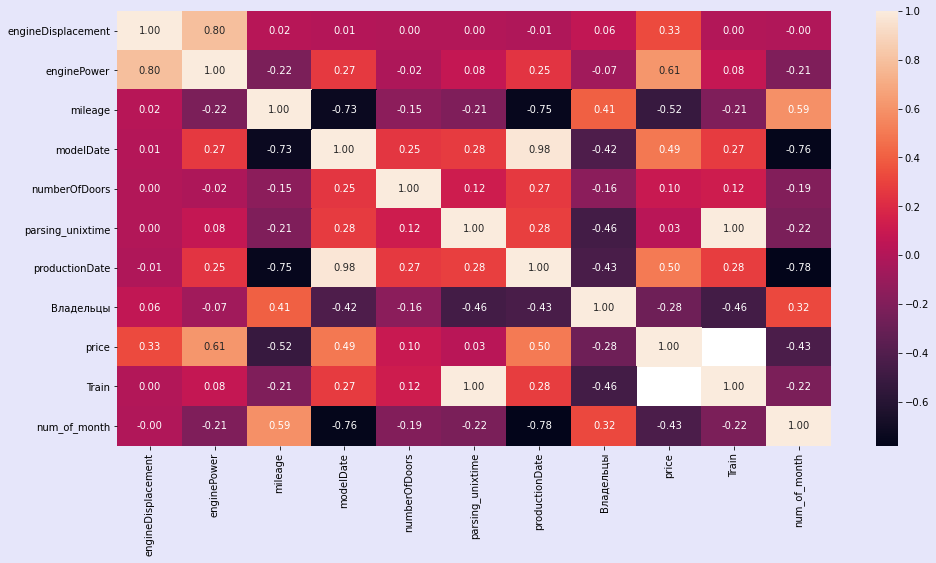

In [100]:
# Посмотрим, что на что влияет.
fig, ax = plt.subplots(figsize=(16,8), facecolor="Lavender")
sns.heatmap(data.corr(), annot=True, fmt=".2f");

Видим сильное влияние даты выпуска и даты представленя модели. Дата выпуска, видим, сильее связана с ценой. Её и оставлю.

В первую очередь предлагаю сделать модель на случайном лесе.

### Первая модель

In [101]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'numberOfDoors', 
            'productionDate']

In [102]:
# Случайный лес.
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [103]:
# Готовим наборы.
X_train, X_test, y = splitter(data, cat_cols, num_cols)

In [104]:
# Учим модель.
model_fit(model, X_train, y)

MAPE на тренеровочном наборе: 7.067582479009974
MAPE на перекрёстной проврке: 17.001903609937813 ([17.01086121 17.08119447 16.91365515])


In [105]:
model.predict(X_test)

array([1025400., 1512200., 1267600., ...,  293600., 1465300., 1257100.])

### Вторая модель

In [106]:
# Добавим новый столбец.
data['diff_data'] = data['modelDate'] - data['productionDate']

In [107]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'numberOfDoors', 
            'productionDate', 'diff_data']

In [108]:
# Случайный лес.
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [109]:
# Готовим наборы.
X_train, X_test, y = splitter(data, cat_cols, num_cols)

In [110]:
# Учим модель.
model_fit(model, X_train, y)

MAPE на тренеровочном наборе: 7.046851558427797
MAPE на перекрёстной проврке: 16.936132302422934 ([16.93800257 17.12273509 16.74765925])


In [111]:
model.predict(X_test)

array([1062900., 1566000., 1270700., ...,  277700., 1577100., 1257200.])

Стало лучше, запомним.

### Третья модель

In [112]:
# Прологорифмируем мощность двигателя.
data['enginePower_log'] = data['enginePower'].apply(lambda x: np.log(x+1))

In [113]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month']
num_cols = ['engineDisplacement', 'enginePower_log', 'mileage', 'numberOfDoors', 
            'productionDate', 'diff_data']

In [114]:
# Случайный лес.
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [115]:
# Готовим наборы.
X_train, X_test, y = splitter(data, cat_cols, num_cols)

In [116]:
# Учим модель.
model_fit(model, X_train, y)

MAPE на тренеровочном наборе: 7.045956393232096
MAPE на перекрёстной проврке: 16.935601214083317 ([16.93749967 17.12604898 16.74325499])


In [117]:
model.predict(X_test)

array([1062900., 1566000., 1270700., ...,  277700., 1577100., 1256800.])

Стало чуть лучше.

### Четвёртая модель

In [118]:
data['mileage_log'] = data['mileage'].apply(lambda x: np.log(x+1))

In [119]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month']
num_cols = ['engineDisplacement', 'enginePower_log', 'mileage_log', 'numberOfDoors', 
            'productionDate', 'diff_data']

In [120]:
# Случайный лес.
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [121]:
# Готовим наборы.
X_train, X_test, y = splitter(data, cat_cols, num_cols)

In [122]:
# Учим модель.
model_fit(model, X_train, y)

MAPE на тренеровочном наборе: 7.042444776507535
MAPE на перекрёстной проврке: 16.914612400515836 ([16.90659837 17.10643369 16.73080515])


In [123]:
model.predict(X_test)

array([1058700., 1566000., 1270700., ...,  277700., 1578800., 1257300.])

Улучшили, но не так как хотелось бы..

### Пятая модель.

Попробуем поэкспериментировать с super_gen.

In [124]:
# Посмотрим, что там есть полезного.
sg_df.head()

,id,name,ru_name,year_from,year_to,price_segment,purpose_group,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max
0,2310047,I Рестайлинг,1 Рестайлинг,2006,2014,PREMIUM,BUSINESS,False,False,False,False,False,False,False,False,False,False,False,False
1,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False
2,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False
3,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False
4,20012324,I Рестайлинг,1 Рестайлинг,2013,2017,PREMIUM,FAMILY,False,False,False,False,False,False,False,False,False,False,False,False


In [125]:
# Очень интересные столбцы - "year_from", "year_to", "price_segment", "purpose_group".
# year_from
sg_df.year_from.value_counts()

False     34686
2017.0     4617
2020.0     4182
2019.0     3419
2018.0     3093
          ...  
1954.0        1
1953.0        1
1949.0        1
1973.0        1
1937.0        1
Name: year_from, Length: 68, dtype: int64

In [126]:
# year_to
sg_df.year_to.value_counts()

False     34686
2021.0    15974
2015.0     3077
2020.0     3048
2013.0     3032
2017.0     2778
2019.0     2487
2014.0     2251
2018.0     1815
2010.0     1656
2012.0     1610
2016.0     1558
2009.0     1407
2011.0     1203
2006.0      905
2008.0      809
2007.0      793
2004.0      511
2003.0      451
2001.0      414
2000.0      411
2005.0      362
2002.0      328
1999.0      323
1997.0      278
1998.0      191
1992.0      141
1996.0      140
1994.0      128
1993.0      103
1995.0       49
1988.0       30
1991.0       28
1985.0       28
1989.0       17
1986.0       12
1990.0        9
1983.0        6
1971.0        5
1980.0        3
1984.0        3
1987.0        3
1963.0        3
1958.0        2
1955.0        2
1957.0        2
1960.0        2
1950.0        1
1953.0        1
1961.0        1
1959.0        1
1979.0        1
1962.0        1
1970.0        1
1972.0        1
1977.0        1
Name: year_to, dtype: int64

In [127]:
# price_segment
sg_df.price_segment.value_counts()

False      34686
PREMIUM    23731
MEDIUM     21156
ECONOMY     3510
Name: price_segment, dtype: int64

In [128]:
# purpose_group
sg_df.purpose_group.value_counts()

False       34686
FAMILY      33726
BUSINESS    12846
CITY         1825
Name: purpose_group, dtype: int64

И что у нас получается?
Посмотрим на хвост.

In [129]:
sg_df.tail()

,id,name,ru_name,year_from,year_to,price_segment,purpose_group,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max
83078,8546464,316,False,False,False,False,False,1598,GASOLINE,REAR_DRIVE,AUTOMATIC,136,100,316i 1.6 AT (136 л.с.),9.2,140,5.8,316i,False
83079,20856402,520,False,False,False,False,False,1995,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,190,140,520d xDrive 2.0d AT (190 л.с.) 4WD,7.6,139,4.9,520d xDrive,False
83080,6329747,523,False,False,False,False,False,2494,GASOLINE,REAR_DRIVE,AUTOMATIC,170,125,523i 2.5 AT (170 л.с.),9.6,120,10.3,523i,False
83081,8247004,20d,False,False,False,False,False,1995,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,184,135,20d 2.0d AT (184 л.с.) 4WD,8.1,195,5.4,20d,False
83082,20390090,30d,False,False,False,False,False,2993,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,235,173,30d 3.0d AT (235 л.с.) 4WD,8.1,222,8.2,30d,False


Похоже у нас в тестовом наборе нет этих признаков. Что делать с ними совсем не понятно.
Зато есть другие, посмотрим на них: это расход топлива, клиренс, и как я понимаю разгон до 100.

In [130]:
# Разгон до 100.
sg_df.acceleration.value_counts()

False    50342
10.5       825
9.9        717
9.0        691
8.5        664
         ...  
18.8         1
18.7         1
29.4         1
20.0         1
6.31         1
Name: acceleration, Length: 182, dtype: int64

In [131]:
# Расход топлива..
sg_df.fuel_rate.value_counts()

False    51873
6.7        977
7.4        860
7.1        836
7.9        792
         ...  
15.2         1
18.5         1
3.7          1
0.7          1
2.6          1
Name: fuel_rate, Length: 148, dtype: int64

In [132]:
# Клиренс.
sg_df.clearance_min.value_counts()

False    49348
150.0     3557
200.0     2340
160.0     2252
165.0     1891
         ...  
286.0        1
112.0        1
243.0        1
261.0        1
198.0        1
Name: clearance_min, Length: 141, dtype: int64

Снова большие пробелы..
Посмотрим на моду.

In [133]:
print(f'Мода: разгон до 100 = {sg_df[sg_df.acceleration != False].acceleration.mode().values[0]}')
print(f'Мода: расход топлива = {sg_df[sg_df.fuel_rate != False].fuel_rate.mode().values[0]}')
print(f'Мода: клиренс = {sg_df[sg_df.clearance_min != False].clearance_min.mode().values[0]}')

Мода: разгон до 100 = 10.5
Мода: расход топлива = 6.7
Мода: клиренс = 150.0


In [134]:
# Есть предложение заполнить все пропуски (там где False) модой
sg_df.loc[sg_df.acceleration == False,'acceleration'] = 10.5
sg_df.loc[sg_df.fuel_rate == False,'fuel_rate'] = 6.7
sg_df.loc[sg_df.clearance_min == False,'clearance_min'] = 150.0

In [135]:
# Объединим наборы.
data_ext = data.copy() # Создаём копию.
data_ext = pd.concat([data, sg_df], axis=1)
data_ext.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,Train,num_of_month,diff_data,enginePower_log,mileage_log,id,name,ru_name,year_from,year_to,price_segment,purpose_group,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max
0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1104...,синий,"{'id': '20013525', 'name': 'Executive (5 мест)...",В нашем автосалоне Вы можете автомобиль - купи...,2400.0,163.0,"{'cruise-control': True, 'esp': True, 'usb': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/356459...,274000,2006,"{'code': 'XC90', 'name': 'XC90', 'ru_name': 'X...",XC90,2.4d MT (163 л.с.) 4WD,5,1633157084000,2010,1104248897-2c4e63f6,"{'id': '2310047', 'name': 'I Рестайлинг', 'ru_...",ALLROAD_5_DOORS MECHANICAL 2.4,механическая,EUROPEAN,2,nodata,Оригинал,полный,Левый,1110000.0,1,132,-4,5.099866,12.520887,2310047,I Рестайлинг,1 Рестайлинг,2006,2014,PREMIUM,BUSINESS,False,False,False,False,False,False,False,10.5,150,6.7,False,False
1,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/new/sale/volvo/xc60/11047...,чёрный,"{'id': '22174038', 'name': 'Momentum', 'availa...",Узнайте вашу выгоду на автомобили VOLVO в Inch...,2000.0,235.0,"{'cruise-control': True, 'asr': True, 'esp': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/523445...,0,2017,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.0d AT (235 л.с.) 4WD,5,1627479445000,2021,1104737585-9b835e4b,"{'id': '20950306', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,0,nodata,Оригинал,полный,Левый,5300000.0,1,0,-4,5.463832,0.000000,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,10.5,150,6.7,False,False
2,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/new/sale/volvo/xc60/11047...,чёрный,"{'id': '22174500', 'name': 'Inscription', 'ava...",Узнайте вашу выгоду на автомобили VOLVO в Inch...,2000.0,190.0,"{'cruise-control': True, 'asr': True, 'esp': T...",дизель,//avatars.mds.yandex.net/get-autoru-vos/523227...,0,2017,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.0d MT (190 л.с.) 4WD,5,1627472315000,2021,1104737644-e72a63a3,"{'id': '20950306', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS MECHANICAL 2.0,механическая,EUROPEAN,0,nodata,Оригинал,полный,Левый,5330000.0,1,0,-4,5.252273,0.000000,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,10.5,150,6.7,False,False
3,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1105...,чёрный,"{'id': '22174038', 'name': 'Momentum', 'availa...",💸Выгода до 100 000 рублей при покупке в кредит...,2000.0,190.0,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,//avatars.mds.yandex.net/get-autoru-vos/528963...,27000,2017,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.0 AT (190 л.с.),5,1633156097000,2020,1105077546-8866490f,"{'id': '20950306', 'name': 'II', 'ru_name': '2...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,1,nodata,Оригинал,передний,Левый,3820000.0,1,12,-3,5.252273,10.203629,20950306,II,2,2017,2021,PREMIUM,FAMILY,False,False,False,False,False,False,False,10.5,150,6.7,False,False
4,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1105...,белый,"{'id': '0', 'name': ''}",Автомобили с пробегом от Официального Дилера У...,2400.0,220.0,"{'tinted-glass': True, 'airbag-driver': True, ...",дизель,//avatars.mds.yandex.net/get-autoru-vos/515126...,114000,2013,"{'code': 'XC60', 'name': 'XC60', 'ru_name': 'X...",XC60,2.4d AT (220 л.с.) 4WD,5,1633157064000,2014,1105477413-6b6e32cd,"{'id': '20012324', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,1,nodata,Оригинал,полный

In [136]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month']
num_cols = ['engineDisplacement', 'enginePower_log', 'mileage_log', 'numberOfDoors', 
            'productionDate', 'diff_data'] + ['acceleration', 'fuel_rate', 'clearance_min']

In [137]:
# Случайный лес.
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [138]:
# Готовим наборы.
X_train, X_test, y = splitter(data_ext, cat_cols, num_cols)

In [139]:
# Учим модель.
model_fit(model, X_train, y)

MAPE на тренеровочном наборе: 7.042861005664049
MAPE на перекрёстной проврке: 16.915640622296447 ([16.9453502  17.09900376 16.70256791])


In [140]:
model.predict(X_test)

array([1058500., 1540600., 1278200., ...,  276700., 1542700., 1267200.])

Стало хуже только. Плохая была идея.

### Попробуем  equipment_dict.

In [141]:
# Объединим наборы.
data_ext = data.copy() # Создаём копию.
data_ext = pd.concat([data, eq_df], axis=1)
data_ext.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,Train,num_of_month,diff_data,enginePower_log,mileage_log,cruise-control,esp,usb,windcleaner-heat,multi-wheel,xenon,heated-wash-system,airbag-passenger,roof-rails,lock,electro-mirrors,electro-window-back,18-inch-wheels,mirrors-heat,volume-sensor,body-mouldings,rear-seats-heat,leather,seat-memory,music-super,park-assist-r,engine-proof,front-seats-heat-vent,airbag-driver,isofix,aux,electro-window-front,light-sensor,automatic-lighting-control,airbag-curtain,passenger-seat-updown,collision-prevention-assist,computer,seat-transformation,wheel-power,alarm,passenger-seat-electric,light-cleaner,dha,alloy-wheel-disks,ptf,leather-gear-stick,rain-sensor,airbag-side,seats-5,tyre-pressure,migration-flag,abs,front-seats-heat,wheel-configuration2,wheel-leather,wheel-configuration1,immo,light-interior,climate-control-2,auto-mirrors,12v-socket,third-rear-headrest,asr,audiosystem-tv,lane-keeping-assist,front-centre-armrest,navigation,bas,rear-camera,door-sill-panel,servo,drl,park-assist-f,wheel-heat,led-lights,glonass,start-stop-function,drive-mode-sys,hcc,high-beam-assist,keyless-entry,driver-seat-electric,fabric-seats,traffic-sign-recognition,voice-recognition,electronic-gage-panel,electro-trunk,bluetooth,windscreen-heat,front-seat-support,decorative-interior-lighting,easy-trunk-opening,19-inch-wheels,start-button,reduce-spare-wheel,driver-seat-memory,tinted-glass,audiopreparation,airbag-rear-side,17-inch-wheels,climate-control-1,knee-airbag,feedback-alarm,remote-engine-start,audiosystem-cd,dark-interior,e-adjustment-wheel,paint-metallic,blind-spot,massage-seats,auto-cruise,20-inch-wheels,hatch,panorama-roof,power-child-locks-rear-doors,seats-2,adaptive-light,programmed-block-heater,auto-park,220v-socket,drowsy-driver-alert-system,android-auto,seats-7,third-row-seats,black-roof,ashtray-and-cigarette-lighter,apple-carplay,air-suspension,steering-wheel-gear-shift-paddles,multizone-climate-control,roller-blinds-for-rear-side-windows,projection-display,360-camera,combo-interior,laminated-safety-glass,wheel-memory,cooling-box,folding-front-passenger-seat,wireless-charger,16-inch-wheels,spare-wheel,isofix-front,driver-seat-updown,sport-seats,sport-pedals,body-kit,sport-suspension,electro-rear-seat,driver-seat-support,eco-leather,seats-6,218,345,440,632,873,airbrush,entertainment-system-for-rear-seat-passengers,500,activ-suspension,51U,234,401,443,810,872,21-inch-wheels,power-latching-doors,velvet-seats,228,22-inch-wheels,laser-lights,vsm,roller-blind-for-rear-window,rear-seat-heat-vent,540,597,881,rear-seat-memory,U25,turnbuckle,840,steel-wheels,condition,adj-pedals,alcantara,rcta,15-inch-wheels,gbo,night-vision,folding-tables-rear,seats-4,ya-auto,12-inch-wheels,seats-8,14-inch-wheels,61U,301,seats-9,front-camera,duo-body-color,608,armored,dual-xenon,23-inch-wheels,13-inch-wheels,4D3,9VS,6NQ,8X1,3S1,8T2,24-inch-wheels,seats-heat,electro-window-all,electro-seat,parktronik,airbag-4,advanced-frontlighting-system,driver-seat-manual,halogen,airbag-7,airbag-2,airbag-1,passenger-seat-memory,climate-control,immobiliser-not-standard,wheel-configuration3,28-inch-wheels,passenger-seat-manual,PX2,KA2,3L5,6XF,N4M,climate-control-3,airbag-8,313,414,27-inch-wheels,F62,6E3,4A3,F48,9R1,3FB,PE6,8RF,8RM,239,7X5,357,audiosystem,PCH,PW1,8T6,PL2,9S6,9P5,RAB,PN0,PB0,6XE,PNQ,airbag-6,25-inch-wheels,235,242,246,249,270,274,351,364,367,431,448,475,501,513,551,670,728,772,776,807,824,871,882,883,889,927,989,U09,H06,U22,DZ9,P17,B63,RVR,14U,R66,P29,03B,P31,16U,P44,R01,B16,17U,L5C,WVA,S7N,E0P,2C5,1N1,7AA,9AB,UI4,6XD,3B3,7B2,9S3,4I2,3NZ,4UC,4UE,4R2,4R3,6R1,9T1,3Q6
0,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1104...,синий,"{'id': '20013525', '

In [142]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month'] + list(eq_df.columns.values)
num_cols = ['engineDisplacement', 'enginePower_log', 'mileage_log', 'numberOfDoors', 
            'productionDate', 'diff_data']

In [143]:
# Случайный лес.
model = RandomForestRegressor(100, random_state=RANDOM_STATE)

In [144]:
# Готовим наборы.
X_train, X_test, y = splitter(data_ext, cat_cols, num_cols)

In [145]:
# Учим модель.
model_fit(model, X_train, y)

MAPE на тренеровочном наборе: 5.958720394824852
MAPE на перекрёстной проврке: 16.215020916305765 ([16.321136   16.54230145 15.78162529])


Стало лучше, но слишком долго обучается модель, надо что-то сделать.

In [146]:
# Поскольку набор очень велик, посмотрим лучшие признаки для eq_df.
# Берём все лучшие признаки.
top_features = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).index

# Фильтруем и берём 100 лучших.
top_features = top_features[top_features.isin(eq_df.columns)]
top_features = eq_df.columns[:100]

# Выводим на печать.
print(top_features)


Index(['cruise-control', 'esp', 'usb', 'windcleaner-heat', 'multi-wheel',
       'xenon', 'heated-wash-system', 'airbag-passenger', 'roof-rails', 'lock',
       'electro-mirrors', 'electro-window-back', '18-inch-wheels',
       'mirrors-heat', 'volume-sensor', 'body-mouldings', 'rear-seats-heat',
       'leather', 'seat-memory', 'music-super', 'park-assist-r',
       'engine-proof', 'front-seats-heat-vent', 'airbag-driver', 'isofix',
       'aux', 'electro-window-front', 'light-sensor',
       'automatic-lighting-control', 'airbag-curtain', 'passenger-seat-updown',
       'collision-prevention-assist', 'computer', 'seat-transformation',
       'wheel-power', 'alarm', 'passenger-seat-electric', 'light-cleaner',
       'dha', 'alloy-wheel-disks', 'ptf', 'leather-gear-stick', 'rain-sensor',
       'airbag-side', 'seats-5', 'tyre-pressure', 'migration-flag', 'abs',
       'front-seats-heat', 'wheel-configuration2', 'wheel-leather',
       'wheel-configuration1', 'immo', 'light-interior', '

### GradientBoostingRegressor.

На данный момент попробуем сделать модель с бустингом. Причём параметры, а именно количество оценщиков будем выбирать на основе алгоритмов описанных в книге О. Жерона "Прикладное машинное обучение с помощью Scikit-Learn и TensorFlow".

In [147]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month'] + list(top_features)
num_cols = ['engineDisplacement', 'enginePower_log', 'mileage_log', 'numberOfDoors', 
            'productionDate', 'diff_data']

In [148]:
# Готовим наборы.
X_train, X_test, y = splitter(data_ext, cat_cols, num_cols)

In [149]:
# Попробуем реализовать алгоритм наиболее перспективного числа оценщиков.
# Инициализируем регрессор и разбиваем наборы.
gbrt = GradientBoostingRegressor(max_depth=20 , n_estimators= 1000)
X_train_, X_val_, y_train, y_val = train_test_split(X_train, y)

# Обучаем.
gbrt.fit(X_train_ , y_train )

# Вычисляем ск. ошибку.
errors = [ mean_squared_error (y_val, y_pred ) for y_pred in gbrt.staged_predict ( X_val_ ) ]
bst_n_estimators = np.argmin ( errors )
print(f'Оптимальное количесвто оценщиков = {bst_n_estimators}')

# Нашли самый оптимальный параметр и попробуем обучиться с ним.
gbrt_best = GradientBoostingRegressor (max_depth=20 ,n_estimators=bst_n_estimators )
model_fit(gbrt_best, X_train, y)

Оптимальное количесвто оценщиков = 42
MAPE на тренеровочном наборе: 4.484197605856522
MAPE на перекрёстной проврке: 18.878903990376347 ([18.97549902 19.29639215 18.3648208 ])


Неплохо вышло, имеет смысл оставить.

### XGBOOST

Попробуем другую библиотеку бустинга. К сожалению, мне не удалось выполнить предыдущий трюк ввиду особенностей этой библиотеки.

In [150]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month'] + list(top_features)
num_cols = ['engineDisplacement', 'enginePower_log', 'mileage_log', 'numberOfDoors', 
            'productionDate', 'diff_data']

In [151]:
# Готовим наборы.
X_train, X_test, y = splitter(data_ext, cat_cols, num_cols)

In [152]:
# Попробуем новую модель.
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.1, 
                          max_depth=12, alpha=1, n_estimators=100, silent=1)

In [153]:
# Учим модель.
model_fit(xgb_model, X_train, y)

[22:28:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MAPE на тренеровочном наборе: 10.40531803837162
MAPE на перекрёстной проврке: 17.280654325193712 ([17.15910205 17.3756028  17.30725813])


### Случайный лес (1000 элементов)

In [154]:
# Выделим категориальные и числовые признаки.
cat_cols = ['bodyType', 'brand', 'color', 'model_name', 'fuelType', 'vehicleTransmission',
            'vendor', 'ПТС', 'Привод', 'Руль', 'Владельцы', 'num_of_month'] + list(top_features)
num_cols = ['engineDisplacement', 'enginePower_log', 'mileage_log', 'numberOfDoors', 
            'productionDate', 'diff_data']

In [155]:
# Готовим наборы.
X_train, X_test, y = splitter(data_ext, cat_cols, num_cols)

In [156]:
# Случайный лес.
model_ext = RandomForestRegressor(1000, random_state=RANDOM_STATE)

In [157]:
# Учим модель.
model_fit(model_ext, X_train, y)

MAPE на тренеровочном наборе: 5.9126345847030395
MAPE на перекрёстной проврке: 16.195900099465998 ([16.24080254 16.48912428 15.85777347])


## Стекинг

Стекинг был организован согласно концепции, указанной в книге О. Жерона "Прикладное машинное обучение с помощью Scikit-Learn и TensorFlow".

In [158]:
# Будем использовать 3 фолда.
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [159]:
# Готовим трейн и тестовый набор для стекинга.
sf_train, sf_test = generate_meta_features([
    RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=RANDOM_STATE),
    GradientBoostingRegressor(n_estimators=bst_n_estimators, random_state=RANDOM_STATE),
    xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.1, max_depth=12, alpha=1, n_estimators=1000, silent=1),
], X_train.values, X_test.values, y.values, cv)

 67%|██████████████████████████▋             | 2/3 [1:26:31<57:56, 3476.81s/it]

[02:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:34:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

100%|████████████████████████████████████████| 3/3 [2:02:01<00:00, 2440.59s/it]


In [160]:
# Запускаем стекинг.
stack_model = RandomForestRegressor()
stack_model.fit(sf_train, y)

RandomForestRegressor()

In [161]:
# Что там получилось?
mape_calc(y, stack_model.predict(sf_train))

6.134955602409925

In [162]:
# Запишем сабмит.
write_submition(data_ext, stack_model, sf_test, './submission.csv')

## 2.7 Выводы.

В данной работе была сделана попытка построить модель регрессии для задачи оценки авто.

Ноутбук выполняется достаточно долго (6-7 часов), по этой причине надо либо уменьшать количество оценщиков в ущерб точности, либо просто создать условия, чтобы комп не засыпал ни при выполнении настоящего ноутбука, ни на соревновании на платформе Kaggle. У меня это получилось не сразу, пару раз я пропускал этот момент на платформе Kaggle. И тогда платформа "не узнавала" меня, и не подключалась к запущенной сесси. Поэтому мне приходилсь вновь запускать и дежурить. Учитывая полностью загруженный рабочий день дежурства были ночными. Удалось это сделать только лишь накануне выходных.

Скромные результаты моей работы (40.3) связываю с недостаточным объёмом тренировочных данных и с тем, что цены на авто существенно поднялись за этот год, а испытательные данные устарели. Полагаю, если обновить испытательные данные конкурса, результаты подтянутся. Хотя не исключаю вероятности, что я не прав и допустил страшное переобучение или просто ещё плохо умею работать.

Но я стараюсь. Дорогу осилит идущий.

Спасибо за задачу и Ваше внимание.

P.S. По поводу опечаток: я ошибочно писал "тренЕровочный" вместо правильного "тренИровочный". Здесь я поправил код и описание, но выдачу процедур уже не смогу без перезапуска. В скором времени я всё поправлю.